# TopicBank: Model Validation Experiment

Here we are going to estimate model quality using topic bank, which was created earlier in the notebook [Topic Bank Experiment: Bank Creation](TopicBank-Experiment-BankCreation.ipynb)

# Contents<a id="contents"></a>

* [Data Loading](#data-loading)
* [Bank Loading](#bank-loading)
* [Experiment](#experiment)
    * [Fixing Regularizer Parameters](#fixing-params)
        * [Decorrelation](#fixing-decorrelation)
        * [Topic Selection](#fixing-topic-selection)
        * [Sparsing](#fixing-sparsing)
        * [Smoothing](#fixing-smoothing)
    * [Model Quality Estimation](#model-quality-estimation)
        * [PLSA](#estimation-plsa)
        * [Regularized 1](#estimation-regularized1)
        * [Background Topics](#estimation-background)
        * [Arora & CDC](#estimation-arora-and-cdc)
        * [LDA, Sparse, Decorrelation & Regularized 2](#estimation-lda-and-all-all-all)
        * [Topic Selection & Decorrelation. All at Once but One after Another](#estimation-selection-plus-decorrelation1)
        * [Topic Selection & Decorrelation. Changing Parameters](#estimation-selection-plus-decorrelation2)
        * [Topic Selection & Decorrelation. Alternating Order](#estimation-selection-plus-decorrelation3)
        * [Topic Selection & Decorrelation. Alternating Order & Changing Parameters](#estimation-selection-plus-decorrelation4)
* [Results](#results)
    * [Fixing Keys](#results-fixing-keys)
    * [Averaging](#results-averaging)
    * [Aggregating](#results-aggregating)
    * [Plots](#results-plots)

In [ ]:
# General imports

import copy
import dill
import itertools
import json
import numpy as np
import os
import pandas as pd
import tempfile

from copy import deepcopy
from datetime import datetime
from enum import Enum
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import (
    Callable,
    Dict,
    List,
)

%matplotlib inline

In [ ]:
plt.rcParams['font.size']

10.0

In [ ]:
plt.rcParams.update({'font.size': 20})

In [ ]:
# Specific

from lapsolver import solve_dense

In [ ]:
# Making `topnum` module visible for Python

import sys

sys.path.insert(0, '..')

In [ ]:
# Optimal number of topics

import artm

from topicnet.cooking_machine import (
    Dataset,
    Experiment,
)
from topicnet.cooking_machine.cubes import (
    RegularizationControllerCube,
    RegularizersModifierCube,
)
from topicnet.cooking_machine.models import (
    TopicModel,
    BaseScore,
)
# from topicnet.cooking_machine.recipes import IntratextCoherenceRecipe
from topicnet.cooking_machine.model_constructor import add_standard_scores
from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.model_constructor import (
    init_model_from_family,
    KnownModel,
)
from topnum.scores import (
    IntratextCoherenceScore,
    SparsityPhiScore,
    SparsityThetaScore,
    SimpleTopTokensCoherenceScore,
    SophisticatedTopTokensCoherenceScore,
)
from topnum.scores._base_coherence_score import (
    SpecificityEstimationMethod,
    TextType,
    WordTopicRelatednessType
)
from topnum.scores.intratext_coherence_score import ComputationMethod
from topnum.search_methods import TopicBankMethod
from topnum.search_methods.topic_bank.topic_bank import TopicBank
from topnum.search_methods.topic_bank.one_model_train_funcs import (
    default_train_func,
    regularization_train_func,
    specific_initial_phi_train_func,
    background_topics_train_func,
    _get_topic_model,
    _fit_model_with_scores,
)
from topnum.search_methods.topic_bank.phi_initialization.initialize_phi_funcs import (
    initialize_with_copying_topics
)
from topnum.search_methods.topic_bank.phi_initialization.arora import (
    compute_phi as arora_compute_phi
)
from topnum.search_methods.topic_bank.phi_initialization.cdc import (
    compute_phi as cdc_compute_phi
)

## Data Loading<a id="data-loading"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Datasets are the same, as the ones that were used in the notebook mentioned at the beginning.

In [ ]:
class DatasetName(Enum):
    POSTNAUKA = 'Post_Science'
    REUTERS = 'Reuters'
    BROWN = 'Brown'
    TWENTY_NEWSGROUPS = '20NG_natural_order'
    AG_NEWS = 'AG_News'
    WATAN = 'Watan2004'
    HABRAHABR = 'Habrahabr'

In [ ]:
def get_dataset_internals_folder_path(dataset_name: DatasetName) -> str:
    return os.path.join('.', dataset_name.value + '__internals')

Choosing and initializing a dataset

In [ ]:
DATASET_NAME = DatasetName.POSTNAUKA  # select a dataset here

In [ ]:
DATASET_NAME

<DatasetName.POSTNAUKA: 'Post_Science'>

In [ ]:
DATASET_INTERNALS_FOLDER_PATH = get_dataset_internals_folder_path(
    DATASET_NAME
)

In [ ]:
DATASET_INTERNALS_FOLDER_PATH

'./Post_Science__internals'

In [ ]:
os.listdir(DATASET_INTERNALS_FOLDER_PATH)

['vw.txt',
 'cached_vw_texts',
 '.ipynb_checkpoints',
 'result_combined',
 'quality_estimates__wrong_cdc.json',
 'vocab.txt',
 'quality_estimates.json',
 'dict.dict.txt',
 'new_ppmi_tf_',
 'ppmi_tf_',
 'dict.dict',
 'cooc_values.json',
 'batches',
 'result']

The folder below is assumed to contain all the necessary data files in .csv format.

In [ ]:
DATA_FOLDER_PATH = 'data'

In [ ]:
sorted(os.listdir(DATA_FOLDER_PATH))

['.ipynb_checkpoints',
 '20NG_natural_order.csv',
 '20NG_natural_order_250.csv',
 '20NG_natural_order_40.csv',
 '20NG_natural_order_45.csv',
 '20NG_natural_order_50.csv',
 '20NG_natural_order_55.csv',
 '20NG_natural_order_60.csv',
 '20NG_natural_order_65.csv',
 'AG_News.csv',
 'AG_News_100.csv',
 'AG_News_1000.csv',
 'AG_News_10000.csv',
 'AG_News_250.csv',
 'AG_News_500.csv',
 'Brown.csv',
 'Brown_10.csv',
 'Brown_8.csv',
 'Brown_80.csv',
 'Brown_9.csv',
 'Habrahabr.csv',
 'Habrahabr_100.csv',
 'Habrahabr_15.csv',
 'Habrahabr_50.csv',
 'PScience.csv',
 'PostNauka_natural_order.csv',
 'Post_Science',
 'Post_Science_12.csv',
 'Post_Science_15.csv',
 'Post_Science_18.csv',
 'Post_Science_20.csv',
 'Post_Science_65.csv',
 'Reuters.csv',
 'Reuters_20.csv',
 'Reuters_50.csv',
 'Reuters_60.csv',
 'Reuters_80.csv',
 'Watan2004.csv',
 'Watan2004_10.csv',
 'Watan2004_100.csv',
 'Watan2004_12.csv',
 'Watan2004_15.csv',
 'Watan2004_250.csv']

In [ ]:
# Paths must point to real files on the machine!

DATASET_NAME_TO_DATASET_FILE_PATH = {
    DatasetName.POSTNAUKA: os.path.join(
        DATA_FOLDER_PATH, 'PostNauka_natural_order.csv'
    ),
    DatasetName.REUTERS: os.path.join(
        DATA_FOLDER_PATH, 'Reuters.csv'
    ),
    DatasetName.BROWN: os.path.join(
        DATA_FOLDER_PATH, 'Brown.csv'
    ),
    DatasetName.TWENTY_NEWSGROUPS: os.path.join(
        DATA_FOLDER_PATH, '20NG_natural_order.csv'
    ),
    DatasetName.AG_NEWS: os.path.join(
        DATA_FOLDER_PATH, 'AG_News.csv'
    ),
    DatasetName.WATAN: os.path.join(
        DATA_FOLDER_PATH, 'Watan2004.csv'
    ),
    DatasetName.HABRAHABR: os.path.join(
        DATA_FOLDER_PATH, 'Habrahabr.csv'
    ),
}

In [ ]:
DATASET_FILE_PATH = DATASET_NAME_TO_DATASET_FILE_PATH[DATASET_NAME]

In [ ]:
DATASET_FILE_PATH

'data/PostNauka_natural_order.csv'

In [ ]:
%%time

# If using really big datasets (like Habrahabr),
# one may need to set this equal `False`
KEEP_DATASET_IN_MEMORY = True

DATASET = Dataset(
    DATASET_FILE_PATH,
    internals_folder_path=DATASET_INTERNALS_FOLDER_PATH,
    keep_in_memory=KEEP_DATASET_IN_MEMORY,
)

CPU times: user 831 ms, sys: 0 ns, total: 831 ms
Wall time: 819 ms


In [ ]:
if KEEP_DATASET_IN_MEMORY:
    DOCUMENTS = list(DATASET._data.index)
else:
    DOCUMENTS = list(DATASET._data_index)

NUM_DOCUMENTS = len(DOCUMENTS)

print(f'Num documents: {NUM_DOCUMENTS}')

Num documents: 3446


In [ ]:
DATASET._data.head()

,id,raw_text,vw_text
id,,,
29998.txt,29998.txt,материал отрицательный показатель преломление ...,29998.txt |@word материал отрицательный показа...
7770.txt,7770.txt,культурный код экономика экономист александр а...,7770.txt |@word культурный код экономика эконо...
32230.txt,32230.txt,faq наука третий класс факт эксперимент резуль...,32230.txt |@word faq наука третий класс факт э...
27293.txt,27293.txt,обрушение волна поверхность жидкость математик...,27293.txt |@word обрушение волна поверхность ж...
481.txt,481.txt,существовать ли суперсимметрия мир элементарны...,481.txt |@word существовать ли суперсимметрия ...


In [ ]:
DATASET._modalities

{'@word'}

Creating batches

In [ ]:
DATASET.get_batch_vectorizer()

artm.BatchVectorizer(data_path="./Post_Science__internals/batches", num_batches=4)

Let's filter dictionary

In [ ]:
dictionary = DATASET.get_dictionary()

In [ ]:
dictionary

artm.Dictionary(name=35fae9fe-4f7f-470b-9dea-9bb0300498da, num_entries=82162)

In [ ]:
dictionary.filter(min_df_rate=0.01, max_df_rate=0.5)

artm.Dictionary(name=35fae9fe-4f7f-470b-9dea-9bb0300498da, num_entries=5112)

Saving filtered dictionary

In [ ]:
DATASET._cached_dict = dictionary

In [ ]:
DATASET.get_dictionary()

artm.Dictionary(name=35fae9fe-4f7f-470b-9dea-9bb0300498da, num_entries=5112)

For Arora and CDC methods we will need dataset's vocabulary as a list of words

In [ ]:
artm_model = artm.ARTM(10)

artm_model.initialize(DATASET.get_dictionary())
artm_model.fit_offline(DATASET.get_batch_vectorizer(), 1)

KNOWN_WORDS = list(artm_model.get_phi().index)

del artm_model

In [ ]:
KNOWN_WORDS[:10]

['сменить',
 'запрет',
 'вкус',
 'рыба',
 'тонкость',
 'культ',
 'присваивать',
 'сводиться',
 'презентация',
 'аналогично']

In [ ]:
len(KNOWN_WORDS)

5112

## Bank Loading<a id="bank-loading"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Bank is going to be used for model quality estimation.
Let's load it!

In [ ]:
SEARCH_RESULTS_FOLDER_PATH = os.path.join(
    DATASET_INTERNALS_FOLDER_PATH,
    'result',
)

In [ ]:
SEARCH_RESULTS_FOLDER_PATH

'./Post_Science__internals/result'

In [ ]:
COMBINED_SEARCH_RESULT_FOLDER_PATH = os.path.join(
    DATASET_INTERNALS_FOLDER_PATH,
    'result_combined',
)

COMBINED_BANK_FOLDER_PATH = os.path.join(
    COMBINED_SEARCH_RESULT_FOLDER_PATH,
    'bank',
)

In [ ]:
COMBINED_BANK_FOLDER_PATH

'./Post_Science__internals/result_combined/bank'

In [ ]:
os.listdir(COMBINED_BANK_FOLDER_PATH)

['topic_scores.bin', 'topics.bin']

In [ ]:
TOPIC_BANK = TopicBank(save=False, save_folder_path=COMBINED_BANK_FOLDER_PATH)

Checking if all OK with the bank

In [ ]:
assert len(TOPIC_BANK.topics) > 0

len(TOPIC_BANK.topics)

24

In [ ]:
BANK_PHI = TOPIC_BANK.view_topics()

In [ ]:
BANK_PHI.shape

(2514, 24)

In [ ]:
BANK_PHI.head()

topic_0  topic_1       topic_2       topic_3  \
@word както                  0.0  0.00000  5.497794e-11  0.000000e+00   
      гравитационный         0.0  0.00000  0.000000e+00  0.000000e+00   
      жена                   0.0  0.00139  0.000000e+00  0.000000e+00   
      продолжительность      0.0  0.00000  0.000000e+00  3.470690e-15   
      одновременно           0.0  0.00075  5.159791e-06  7.805681e-09   

                              topic_4       topic_5   topic_6       topic_7  \
@word както              1.985204e-08  2.223492e-14  0.000009  0.000000e+00   
      гравитационный     0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
      жена               0.000000e+00  1.217113e-04  0.000000  3.405896e-15   
      продолжительность  0.000000e+00  0.000000e+00  0.000000  4.282006e-04   
      одновременно       3.031660e-06  5.124066e-09  0.000146  8.667931e-13   

                          topic_8   topic_9  ...      topic_14      topic_15  \
@word както              0.000000  0.000000  ...  4.583967e-11  2.136343e-07   
      гравитационный     0.000000  0.022702  ...  0.000000e+00  0.000000e+00   
      жена               0.000000  0.000000  ...  8.552548e-05  4.613638e-11   
      продолжительность  0.000000  0.000000  ...  0.000000e+00  0.000000e+00   
      одновременно       0.000935  0.000564  ...  1.407077e-09  7.929910e-05   

                             topic_16  topic_17  topic_18  topic_19  topic_20  \
@word както              5.448506e-15  0.000001  0.000000  0.000002  0.000000   
      гравитационный     0.000000e+00  0.003760  0.000000  0.000000  0.005634   
      жена               0.000000e+00  0.000000  0.000252  0.000000  0.000000   
      продолжительность  7.503462e-05  0.000018  0.000000  0.000000  0.000000   
      одновременно       9.453733e-05  0.000171  0.000000  0.000424  0.000567   

                         topic_21      topic_22      topic_23  
@word както              0.000000  0.000000e+00  1.155988e-13  
      гравитационный     0.000000  0.000000e+00  0.000000e+00  
      жена               0.000000  0.000000e+00  0.000000e+00  
      продолжительность  0.000000  0.000000e+00  4.184186e-06  
      одновременно       0.001273  3.243302e-11  9.126395e-10  

[5 rows x 24 columns]

In [ ]:
set(BANK_PHI.index.get_level_values(0))

{'@word'}

In experiments, only one modality was used (plain text).

In [ ]:
MODALITIES_OF_INTEREST = ['@word']
MAIN_MODALITY = '@word'

Bank and dataset should have common modalities!
Otherwise, it would be impossible to compare model topics with bank topics

In [ ]:
DATASET._extract_possible_modalities()

{'@word'}

In [ ]:
BANK_PHI = BANK_PHI.loc[MODALITIES_OF_INTEREST]

In [ ]:
BANK_PHI.head()

topic_0  topic_1       topic_2       topic_3  \
@word както                  0.0  0.00000  5.497794e-11  0.000000e+00   
      гравитационный         0.0  0.00000  0.000000e+00  0.000000e+00   
      жена                   0.0  0.00139  0.000000e+00  0.000000e+00   
      продолжительность      0.0  0.00000  0.000000e+00  3.470690e-15   
      одновременно           0.0  0.00075  5.159791e-06  7.805681e-09   

                              topic_4       topic_5   topic_6       topic_7  \
@word както              1.985204e-08  2.223492e-14  0.000009  0.000000e+00   
      гравитационный     0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
      жена               0.000000e+00  1.217113e-04  0.000000  3.405896e-15   
      продолжительность  0.000000e+00  0.000000e+00  0.000000  4.282006e-04   
      одновременно       3.031660e-06  5.124066e-09  0.000146  8.667931e-13   

                          topic_8   topic_9  ...      topic_14      topic_15  \
@word както              0.000000  0.000000  ...  4.583967e-11  2.136343e-07   
      гравитационный     0.000000  0.022702  ...  0.000000e+00  0.000000e+00   
      жена               0.000000  0.000000  ...  8.552548e-05  4.613638e-11   
      продолжительность  0.000000  0.000000  ...  0.000000e+00  0.000000e+00   
      одновременно       0.000935  0.000564  ...  1.407077e-09  7.929910e-05   

                             topic_16  topic_17  topic_18  topic_19  topic_20  \
@word както              5.448506e-15  0.000001  0.000000  0.000002  0.000000   
      гравитационный     0.000000e+00  0.003760  0.000000  0.000000  0.005634   
      жена               0.000000e+00  0.000000  0.000252  0.000000  0.000000   
      продолжительность  7.503462e-05  0.000018  0.000000  0.000000  0.000000   
      одновременно       9.453733e-05  0.000171  0.000000  0.000424  0.000567   

                         topic_21      topic_22      topic_23  
@word както              0.000000  0.000000e+00  1.155988e-13  
      гравитационный     0.000000  0.000000e+00  0.000000e+00  
      жена               0.000000  0.000000e+00  0.000000e+00  
      продолжительность  0.000000  0.000000e+00  4.184186e-06  
      одновременно       0.001273  3.243302e-11  9.126395e-10  

[5 rows x 24 columns]

In [ ]:
BANK_PHI['topic_23'].sort_values(ascending=False)[:10]

@word  проблема      0.195973
       задача        0.140297
       решать        0.068049
       решение       0.040787
       мышление      0.026376
       творческий    0.010622
       процесс       0.010458
       разный        0.010243
       перед         0.009838
       решаться      0.009392
Name: topic_23, dtype: float64

Keys which are used in quality estimates entity

In [ ]:
KEY_NUM_GOOD_TOPICS   = 'num_good_topics'
KEY_NUM_FOUND_TOPICS  = 'num_found_topics'
KEY_FOUND_TOPICS      = 'found_topics'

KEY_COHERENCE_AT_BANK = 'coherence@bank'
KEY_PRECISION_AT_BANK = 'precision@bank'
KEY_RECALL_AT_BANK    = 'recall@bank'
KEY_COST              = 'cost'
KEY_REVERSED_COST     = 'reversed_cost'

_KEY_NUM_MODEL_TOPICS = '_num_model_topics'
_KEY_NUM_BANK_TOPICS  = '_num_bank_topics'

In [ ]:
class QualityEstimates:
    def __init__(self):
        # This file contains quality estimates as dictionary
        self._save_file_path = os.path.join(
            DATASET_INTERNALS_FOLDER_PATH,
            'quality_estimates.json',
        )
        
        if os.path.isfile(self._save_file_path):
            self._model2estimates = json.loads(
                open(self._save_file_path, 'r').read()
            )
        else:
            self._model2estimates = dict()
    
    def train_models_and_estimate_quality(
            self,
            model_name_prefix: str,
            train_func: Callable,
            seeds: List[int] = None) -> dict:

        if seeds is None:
            seeds = DEFAULT_SEEDS

        result = dict()

        for seed in tqdm(seeds, total=len(seeds), file=sys.stdout):
            topic_model = train_func(
                dataset=DATASET,
                model_number=seed,
                num_topics=NUM_TOPICS,
                num_fit_iterations=NUM_FIT_ITERATIONS,
            )
            model_name = f'{model_name_prefix}_{seed}'

            result[model_name] = self._estimate_model_quality(
                topic_model=topic_model,
            )

        self.update(result)

        return result
    
    def update(self, estimates: dict) -> None:
        self._model2estimates.update(copy.deepcopy(estimates))
        self.save()
    
    def save(self) -> None:
        with open(self._save_file_path, 'w') as f:
            f.write(json.dumps(self._model2estimates))
    
    @classmethod
    def _estimate_model_quality(
            cls,
            topic_model: TopicModel,
            model_phi: pd.DataFrame = None) -> Dict[str, float or List[str]]:

        if model_phi is None:
            model_phi = topic_model.get_phi().loc[MODALITIES_OF_INTEREST]

        costs = [
            [
                TopicBankMethod._jaccard_distance(
                    model_phi.loc[:, model_topic].to_dict(),
                    BANK_PHI.loc[:, bank_topic].to_dict()
                )
                for bank_topic in BANK_PHI.columns
            ]
            for model_topic in model_phi.columns
        ]

        costs = np.array(costs, dtype=np.float32)

        rids, cids = solve_dense(costs)

        result = dict()

        # Estimating for different thresholds:
        # (things will be averaged further to get just one estimate)
        for distance_threshold in np.arange(0.10, 0.91, 0.05):  # TODO: 0.5500000000000002
            num_good_topics = 0
            found_topics = list()

            for r, c in zip(rids, cids):
                if np.min(costs[r, :]) < distance_threshold:
                    num_good_topics += 1

                if np.min(costs[:, c]) < distance_threshold:
                    found_topics.append(BANK_PHI.columns[c])

            num_found_topics = len(found_topics)

            current_result = dict()

            num_model_topics = model_phi.shape[1]
            num_bank_topics = BANK_PHI.shape[1]

            current_result[KEY_NUM_GOOD_TOPICS] = num_good_topics
            current_result[KEY_NUM_FOUND_TOPICS] = num_found_topics
            current_result[KEY_FOUND_TOPICS] = found_topics

            current_result[KEY_COHERENCE_AT_BANK] = num_good_topics / max(1, num_model_topics)
            current_result[KEY_PRECISION_AT_BANK] = num_found_topics / max(1, num_model_topics)
            current_result[KEY_RECALL_AT_BANK] = num_found_topics / max(1, num_bank_topics)
            current_result[KEY_COST] = float(np.sum(costs[rids, cids]))

            # Keys below will be needed for averaging of results obtained
            # for different seeds
            current_result[_KEY_NUM_MODEL_TOPICS] = num_model_topics
            current_result[_KEY_NUM_BANK_TOPICS] = num_bank_topics

            result[distance_threshold] = current_result

        return result

## Experiment<a id="experiment"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Some cells are almosy copy-pasted from the notebook [Making Decorrelation and Topic Selection Friends](https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/demos/Making-Decorrelation-and-Topic-Selection-Friends.ipynb): it concerns a part with finding best regularizer parameters and training strategies with Topic Selection regularizer.

P.S.
Here we fix regularizer parameters once and use them in many model trainings.
Worth to note that TopicNet provides some more refined abilities to conduct experiments.
However, for the task at hand, everything seems to be in place.

In [ ]:
SPARSE_PHI_SPECIFIC     = 'sparse_phi_specific'
SPARSE_THETA_SPECIFIC   = 'sparse_theta_specific'
SMOOTH_PHI_BACKGROUND   = 'smooth_phi_background'
SMOOTH_THETA_BACKGROUND = 'smooth_theta_background'

DECORRELATE_SPECIFIC    = 'decorrelate_specific'
DECORRELATE_BACKGROUND  = 'decorrelate_background'

SELECT_TOPICS           = 'select_topics'


def initialize_smoothing_sparsing_regularizers(
        specific_topic_names: List[str],
        background_topic_names: List[str],
        specific_class_ids: List[str],
        background_class_ids: List[str]) -> List[artm.regularizers.BaseRegularizer]:

    return [
        artm.SmoothSparsePhiRegularizer(
            tau=0,
            name=SPARSE_PHI_SPECIFIC,
            topic_names=specific_topic_names,
            class_ids=specific_class_ids
        ),
        artm.SmoothSparseThetaRegularizer(
            tau=0,
            name=SPARSE_THETA_SPECIFIC,
            topic_names=specific_topic_names
        ),
        artm.SmoothSparsePhiRegularizer(
            tau=0,
            name=SMOOTH_PHI_BACKGROUND,
            topic_names=background_topic_names,
            class_ids=background_class_ids
        ),
        artm.SmoothSparseThetaRegularizer(
            tau=0,
            name=SMOOTH_THETA_BACKGROUND,
            topic_names=background_topic_names
        ),
    ]


def initialize_decorrelating_regularizers(
        specific_topic_names: List[str],
        background_topic_names: List[str],
        specific_class_ids: List[str],
        background_class_ids: List[str]) -> List[artm.regularizers.BaseRegularizer]:

    return [
        artm.DecorrelatorPhiRegularizer(
            tau=0,
            name=DECORRELATE_SPECIFIC,
            topic_names=specific_topic_names,
            class_ids=specific_class_ids,
        ),
        artm.DecorrelatorPhiRegularizer(
            tau=0,
            name=DECORRELATE_BACKGROUND,
            topic_names=background_topic_names,
            class_ids=background_class_ids,
        )
    ]


def initialize_topic_selecting_regularizers(
        specific_topic_names: List[str]) -> List[artm.regularizers.BaseRegularizer]:

    return [
        artm.TopicSelectionThetaRegularizer(
            tau=0,
            name=SELECT_TOPICS,
            topic_names=specific_topic_names
        )
    ]

In [ ]:
WORKING_FOLDER_PATH = tempfile.mkdtemp()

In [ ]:
WORKING_FOLDER_PATH

'/tmp/tmp4f_849va'

This score is acctually optional, but it will help to find the number of active topics in models trained with the use of Topic Selection regularizer

In [ ]:
class ActiveTopicNumberScore(BaseScore):
    """
    Calculates number of active topics, i.e. those ones which have at least one document
    
    """
    def __init__(self, specific_topic_names, dataset, threshold=0):
        """
        threshold — minimum probability p(t | d) to consider the document "d" to be related to the topic "t"
        
        """
        super().__init__()
        
        self._threshold = threshold
        self._specific_topic_names = specific_topic_names
        self._dataset = dataset
        
        self._dataset_file_path = dataset._data_path
        self._dataset_internals_folder_path = dataset._internals_folder_path
        self._keep_dataset_in_memory = dataset._small_data

    def call(self, model):
        return len(self.get_active_topics(model))
    
    def get_active_topics(self, model):
        if len(self._specific_topic_names) == 0:
            raise RuntimeError()

        # CAUTION! If dataset is big, this may lead to notebook crash!
        theta = model._model.transform(self._dataset.get_batch_vectorizer())
        subtheta_values = theta.loc[self._specific_topic_names, :].values
        max_probs = np.max(subtheta_values, axis=1)
        
        return list(np.where(max_probs > self._threshold)[0])

    def save(self, path: str) -> None:
        dataset = self._dataset
        self._dataset = None

        with open(path, 'wb') as f:
            dill.dump(self, f)

        self._dataset = dataset

    @classmethod
    def load(cls, path: str):
        with open(path, 'rb') as f:
            score = dill.load(f)

        score._dataset = Dataset(
            score._dataset_file_path,
            internals_folder_path=score._dataset_internals_folder_path,
            keep_in_memory=score._keep_dataset_in_memory,
        )

        return score

In [ ]:
NUM_SPECIFIC_TOPICS   = 100
NUM_BACKGROUND_TOPICS = 2
NUM_TOPICS            = NUM_SPECIFIC_TOPICS + NUM_BACKGROUND_TOPICS

NUM_PROCESSORS = 1  # can be increased for faster computing

SPECIFIC_TOPIC_NAMES   = [f'spec_topic_{i}' for i in range(NUM_SPECIFIC_TOPICS)]
BACKGROUND_TOPIC_NAMES = [f'back_topic_{i}' for i in range(NUM_BACKGROUND_TOPICS)]

PERPLEXITY_SCORE     = 'PerplexityScore'     # don't change this,
                                             # as it is defined this way
                                             # in TopicNet's function
SPARSITY_PHI_SCORE   = 'SparsityPhiScore'    # ...and this
SPARSITY_THETA_SCORE = 'SparsityThetaScore'  # ...and this
TOPIC_KERNEL_SCORE   = 'TopicKernel'         # ...and this


def initialize_topic_model():
    artm_model = artm.ARTM(
        num_processors=NUM_PROCESSORS,
        topic_names=SPECIFIC_TOPIC_NAMES + BACKGROUND_TOPIC_NAMES,
        cache_theta=False,
        class_ids={
            MAIN_MODALITY: 1.0
        },
        num_document_passes=1,
        dictionary=DATASET.get_dictionary()
    )

    smoothing_sparsing_regularizers = initialize_smoothing_sparsing_regularizers(
        SPECIFIC_TOPIC_NAMES, BACKGROUND_TOPIC_NAMES, [MAIN_MODALITY], [MAIN_MODALITY]
    )
    decorrelating_regularizers = initialize_decorrelating_regularizers(
        SPECIFIC_TOPIC_NAMES, BACKGROUND_TOPIC_NAMES, [MAIN_MODALITY], [MAIN_MODALITY]
    )
    topic_selecting_regularizers = initialize_topic_selecting_regularizers(
        SPECIFIC_TOPIC_NAMES
    )

    for regularizer in (
            smoothing_sparsing_regularizers +
            decorrelating_regularizers +
            topic_selecting_regularizers):

        artm_model.regularizers.add(regularizer, overwrite=True)

    add_standard_scores(
        artm_model,
        DATASET.get_dictionary(),
        main_modality=MAIN_MODALITY,
        all_modalities=MODALITIES_OF_INTEREST,
    )

    topic_model = TopicModel(
        artm_model,
        model_id='Root Model',
    )

    experiment = Experiment(
        experiment_id=datetime.now().strftime('%Y-%m-%d__%H-%M-%S'),
        save_path=os.path.join(WORKING_FOLDER_PATH, 'Experiments'),
        topic_model=topic_model,
    )
    
    return topic_model

In [ ]:
def select_best_model_of_all(
        experiment: Experiment,
        score_name: str = None,
        maximize: bool = None) -> TopicModel:

    if score_name is None:
        score_name = PERPLEXITY_SCORE + MAIN_MODALITY
        maximize = False
    elif maximize is None:
        maximize = True

    best_model = None
    levels = range(1, len(experiment.cubes) + 1)
    
    if maximize:
        criterion = f'{score_name} -> max'
        
        def is_candidate_better_func(candidate_model) -> bool:
            return candidate_model.scores[score_name][-1] > best_model.scores[score_name][-1]
    else:
        criterion = f'{score_name} -> min'
        
        def is_candidate_better_func(candidate_model) -> bool:
            return candidate_model.scores[score_name][-1] < best_model.scores[score_name][-1]

    # TODO: probably need such method in Experiment?
    #  (i.e. "select best of all", not only on level=level)
    for level in levels:
        best_model_candidates = experiment.select(
            criterion,
            level=level
        )

        if len(best_model_candidates) == 0:
            continue

        best_model_candidate = best_model_candidates[0]

        if best_model is None or is_candidate_better_func(best_model_candidate):

            best_model = best_model_candidate
    
    return best_model

### Fixing Regularizer Parameters<a id="fixing-params"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here we are going to find the best $\tau$ parameters for several regularizers.
These $\tau$ values will be used for model training.

In [ ]:
NUM_CUBE_ITERATIONS = 20  # if dataset is big, maybe better to reduce

#### Decorrelation<a id="fixing-decorrelation"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
decorrelating_regularizer_parameters = {
    'regularizer': artm.DecorrelatorPhiRegularizer(
        tau=0,
        name=DECORRELATE_SPECIFIC,
        topic_names=SPECIFIC_TOPIC_NAMES,
        class_ids=[MAIN_MODALITY],
    ),
    'tau_grid': [1, 10, 100, 1000, 1e4, 1e5, 1e6]
}

decorrelating_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=decorrelating_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
decorrelating_cube.parameters

[{'object': <artm.regularizers.DecorrelatorPhiRegularizer at 0x7f7a2b3a80f0>,
  'field': 'tau',
  'values': [1, 10, 100, 1000, 10000.0, 100000.0, 1000000.0]}]

In [ ]:
topic_model = initialize_topic_model()

In [ ]:
%%time

models = decorrelating_cube(topic_model, DATASET)

CPU times: user 8min 16s, sys: 0 ns, total: 8min 16s
Wall time: 8min 3s


In [ ]:
models[0].scores

{'PerplexityScore@all': [2045.630126953125],
 'SparsityThetaScore': [0.0],
 'SparsityPhiScore@word': [0.00038356499862857163],
 'PerplexityScore@word': [2045.630126953125],
 'TopicKernel@word.average_coherence': [0.0],
 'TopicKernel@word.average_contrast': [0.2208368480205536],
 'TopicKernel@word.average_purity': [0.05526959151029587],
 'TopicKernel@word.average_size': [6.882352828979492],
 'TopicKernel@word.coherence': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.contrast': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.purity': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.size': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.tokens': ["NaN (<class 'dict'>)"],
 'ITMScore_caa109b3-8269-4703-a13a-0642339b0bc6': [1.0]}

In [ ]:
topic_model.experiment.models

{'-----------root-----------': Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__19-34-39),
 '--19h34m39s_12d05m2020y---': Model(id=--19h34m39s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-34-39),
 '--19h35m48s_12d05m2020y---': Model(id=--19h35m48s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-34-39),
 '--19h36m56s_12d05m2020y---': Model(id=--19h36m56s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-34-39),
 '--19h38m05s_12d05m2020y---': Model(id=--19h38m05s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-34-39),
 '--19h39m14s_12d05m2020y---': Model(id=--19h39m14s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-34-39),
 '--19h40m22s_12d05m2020y---': Model(id=--19h40m22s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-34-39),
 '--19h41m32s_12d05m2

In [ ]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__19-34-39)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [ ]:
best_model

Model(id=--19h40m22s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-34-39)

In [ ]:
DECORRELATION_TAU = best_model.regularizers[DECORRELATE_SPECIFIC].tau

In [ ]:
DECORRELATION_TAU

100000.0

In [ ]:
list(best_model.scores.keys())

['PerplexityScore@all',
 'SparsityThetaScore',
 'SparsityPhiScore@word',
 'PerplexityScore@word',
 'TopicKernel@word.average_coherence',
 'TopicKernel@word.average_contrast',
 'TopicKernel@word.average_purity',
 'TopicKernel@word.average_size',
 'TopicKernel@word.coherence',
 'TopicKernel@word.contrast',
 'TopicKernel@word.purity',
 'TopicKernel@word.size',
 'TopicKernel@word.tokens',
 'ITMScore_e03a049b-e3db-4062-9571-ba2eeeb14096']

Let's look at Perplexity just in case

In [ ]:
best_model.scores['PerplexityScore@all']

[5099.42919921875,
 2541.597412109375,
 3341.128173828125,
 2556.568115234375,
 2799.26611328125,
 2517.1669921875,
 2640.9140625,
 2487.8046875,
 2518.272705078125,
 2414.964599609375,
 2325.496337890625,
 2278.483154296875,
 2133.992431640625,
 2096.5947265625,
 1957.3326416015625,
 1903.3699951171875,
 1819.0101318359375,
 1769.8944091796875,
 1720.1478271484375,
 1685.354248046875]

In [ ]:
DEFAULT_SCORES_TO_PLOT = [
    'PerplexityScore@all',
    f'TopicKernel{MAIN_MODALITY}.average_size',
    f'SparsityPhiScore{MAIN_MODALITY}',
    'SparsityThetaScore',
]

In [ ]:
def draw_plots(
        model: TopicModel,
        scores: List[str] = None,
        num_cols: int = 2,
        font_size: int = 10) -> None:

    if scores is None:
        scores = DEFAULT_SCORES_TO_PLOT
    
    old_font_size = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': font_size})
    
    num_rows = int(np.ceil(len(scores) / num_cols))

    one_plot_width = 4
    one_plot_heigth = 7
    
    fig, axes = plt.subplots(
        num_rows, num_cols,
        figsize=(num_cols * one_plot_heigth, num_rows * one_plot_width)
    )
    
    iterations = list(range(1, len(model.scores[scores[0]]) + 1))
    
    for i, score in enumerate(scores):
        if num_rows >= 2:
            ax = axes[i // num_cols][i % num_cols]
        else:
            ax = axes[i]
        
        ax.plot(iterations, model.scores[score], lw=5)
        
        ax.set_ylabel(score)
        ax.set_xlabel('Iteration')

    plt.subplots_adjust(
        hspace=0.25, wspace=0.25
    )
    plt.show()
    
    plt.rcParams.update({'font.size': old_font_size})

Looking at the model to check if all OK (if regularizer makes model crazy, one should select another $\tau$!)

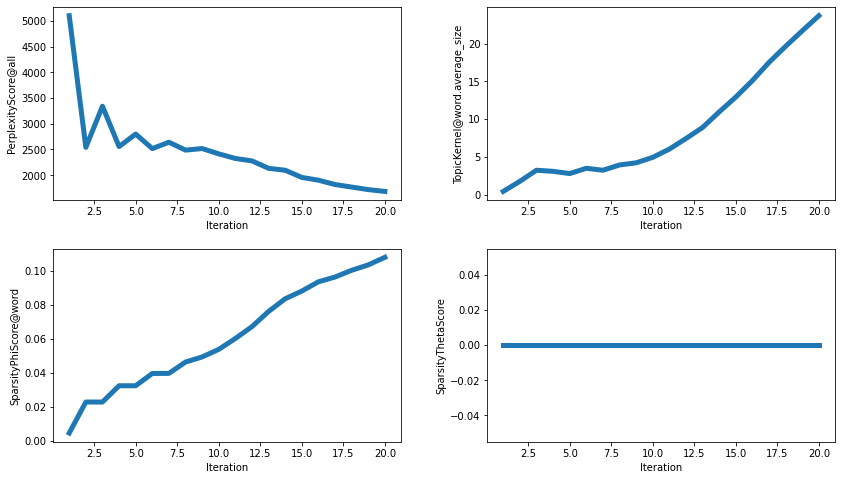

In [ ]:
draw_plots(best_model)

In [ ]:
del decorrelating_regularizer_parameters
del decorrelating_cube

del models
del best_model

Below we are going to do just the same, but for other regularizers

#### Topic Selection<a id="fixing-topic-selection"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
selecting_regularizer_parameters = {
    'regularizer': artm.TopicSelectionThetaRegularizer(
        tau=0,
        name=SELECT_TOPICS,
        topic_names=SPECIFIC_TOPIC_NAMES
    ),
    'tau_grid': [0.01, 0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.0]
}

selecting_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=selecting_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
selecting_cube.parameters

[{'object': <artm.regularizers.TopicSelectionThetaRegularizer at 0x7f7a282740b8>,
  'field': 'tau',
  'values': [0.01, 0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.0]}]

In [ ]:
topic_model = initialize_topic_model()

In [ ]:
%%time

models = selecting_cube(topic_model, DATASET)

CPU times: user 9min 33s, sys: 0 ns, total: 9min 33s
Wall time: 9min 13s


In [ ]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__19-45-01)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [ ]:
best_model.get_phi().shape

(5112, 102)

In [ ]:
%%time

if KEEP_DATASET_IN_MEMORY:
    score = ActiveTopicNumberScore(
        SPECIFIC_TOPIC_NAMES,
        DATASET,
        threshold=1e-7,
    )
    
    print(f'Number of active topics: {score.call(best_model)}')
    
    del score

Number of active topics: 93
CPU times: user 2.94 s, sys: 0 ns, total: 2.94 s
Wall time: 2.83 s


One can see that regularizer really helped to reduce the number of active topics

In [ ]:
%%time

if KEEP_DATASET_IN_MEMORY:
    score = ActiveTopicNumberScore(
        SPECIFIC_TOPIC_NAMES,
        DATASET,
        threshold=1e-7,
    )
    
    for m in models:
        m = m.restore()
        print(m)
        print(f'Number of active topics: {score.call(m)}')
        print(f'Tau: {m.regularizers[SELECT_TOPICS].tau}')
        print()
    
    del score

Model(id=--19h45m02s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-45-01)
Number of active topics: 100
Tau: 0.01

Model(id=--19h46m11s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-45-01)
Number of active topics: 100
Tau: 0.1

Model(id=--19h47m20s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-45-01)
Number of active topics: 100
Tau: 0.2

Model(id=--19h48m29s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-45-01)
Number of active topics: 93
Tau: 0.5

Model(id=--19h49m38s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-45-01)
Number of active topics: 39
Tau: 0.8

Model(id=--19h50m49s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-45-01)
Number of active topics: 0
Tau: 1.0

Model(id=--19h51m57s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19

In [ ]:
SELECTION_TAU = best_model.regularizers[SELECT_TOPICS].tau

In [ ]:
SELECTION_TAU

0.5

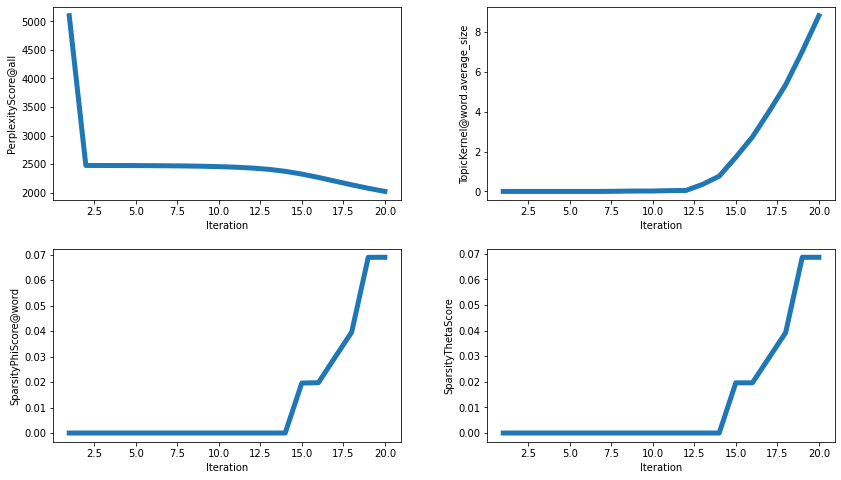

In [ ]:
draw_plots(best_model)

Looking at some topic just in case

In [ ]:
best_model.get_phi()['spec_topic_12'].sort_values(ascending=False)

modality  token     
@word     власть        2.789155e-02
          век           2.204077e-02
          король        1.741424e-02
          империя       1.166300e-02
          святой        1.066250e-02
                            ...     
          карлик        2.494538e-13
          метан         1.141854e-13
          нейтронный    6.600320e-15
          num           0.000000e+00
          pcourse       0.000000e+00
Name: spec_topic_12, Length: 5112, dtype: float32

In [ ]:
del selecting_regularizer_parameters
del selecting_cube

del best_model
del models

#### Sparsing<a id="fixing-sparsing"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
sparsing_regularizer_parameters = {
    'regularizer': artm.SmoothSparsePhiRegularizer(
        tau=0,
        name=SPARSE_PHI_SPECIFIC,
        topic_names=SPECIFIC_TOPIC_NAMES,
        class_ids=[MAIN_MODALITY]
    ),
    'tau_grid': [-10, -1, -0.2, -0.1, -0.02, -0.01, -0.001]
}

sparsing_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=sparsing_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
sparsing_cube.parameters

[{'object': <artm.regularizers.SmoothSparsePhiRegularizer at 0x7f7a29604ba8>,
  'field': 'tau',
  'values': [-10, -1, -0.2, -0.1, -0.02, -0.01, -0.001]}]

In [ ]:
topic_model = initialize_topic_model()

In [ ]:
%%time

models = sparsing_cube(topic_model, DATASET)

CPU times: user 8min 40s, sys: 1.97 s, total: 8min 42s
Wall time: 8min 12s


In [ ]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__19-59-18)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [ ]:
best_model

Model(id=--20h00m29s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__19-59-18)

In [ ]:
for m in models:
    print(m.model_id, m.scores['PerplexityScore@all'][-1])

--19h59m20s_12d05m2020y--- 1901.6947021484375
--20h00m29s_12d05m2020y--- 1766.531005859375
--20h01m40s_12d05m2020y--- 1899.33740234375
--20h02m50s_12d05m2020y--- 1956.533935546875
--20h04m00s_12d05m2020y--- 2022.3936767578125
--20h05m10s_12d05m2020y--- 2033.2852783203125
--20h06m19s_12d05m2020y--- 2044.3175048828125


In [ ]:
SPARSING_TAU = best_model.regularizers[SPARSE_PHI_SPECIFIC].tau

In [ ]:
SPARSING_TAU

-1

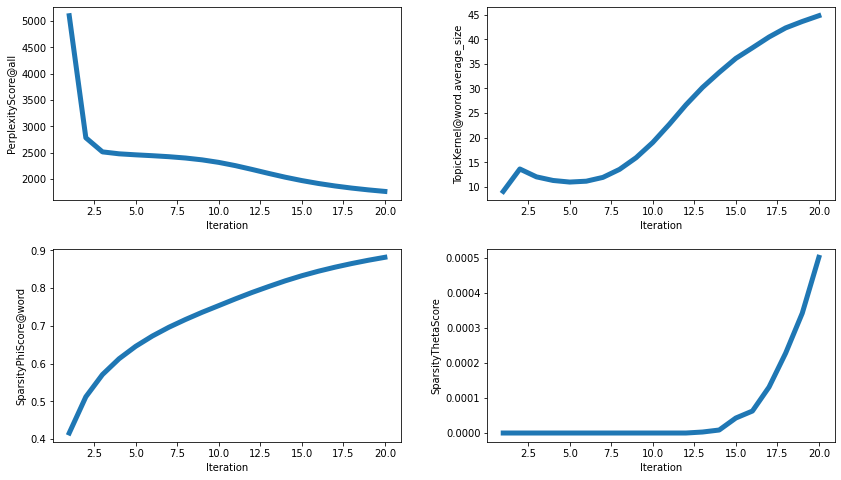

In [ ]:
draw_plots(best_model)

In [ ]:
del sparsing_regularizer_parameters
del sparsing_cube

del best_model
del models

#### Smoothing<a id="fixing-smoothing"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
smoothing_regularizer_parameters = {
    'regularizer': artm.SmoothSparsePhiRegularizer(
        tau=0,
        name=SMOOTH_PHI_BACKGROUND,
        topic_names=BACKGROUND_TOPIC_NAMES,
        class_ids=[MAIN_MODALITY]
    ),
    'tau_grid': [0.001, 0.01, 0.02, 0.1, 1.0, 10.0]
}

smoothing_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=smoothing_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
smoothing_cube.parameters

[{'object': <artm.regularizers.SmoothSparsePhiRegularizer at 0x7f7a2921b828>,
  'field': 'tau',
  'values': [0.001, 0.01, 0.02, 0.1, 1.0, 10.0]}]

In [ ]:
topic_model = initialize_topic_model()

In [ ]:
%%time

models = smoothing_cube(topic_model, DATASET)

CPU times: user 7min 31s, sys: 1.97 s, total: 7min 33s
Wall time: 7min 1s


In [ ]:
topic_model.experiment.models

{'-----------root-----------': Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__20-13-12),
 '--20h13m12s_12d05m2020y---': Model(id=--20h13m12s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__20-13-12),
 '--20h14m22s_12d05m2020y---': Model(id=--20h14m22s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__20-13-12),
 '--20h15m32s_12d05m2020y---': Model(id=--20h15m32s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__20-13-12),
 '--20h16m42s_12d05m2020y---': Model(id=--20h16m42s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__20-13-12),
 '--20h17m51s_12d05m2020y---': Model(id=--20h17m51s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__20-13-12),
 '--20h19m01s_12d05m2020y---': Model(id=--20h19m01s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__20-13-12)}

In [ ]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__20-13-12)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [ ]:
best_model

Model(id=--20h14m22s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__20-13-12)

In [ ]:
SMOOTHING_TAU = best_model.regularizers[SMOOTH_PHI_BACKGROUND].tau

In [ ]:
SMOOTHING_TAU

0.01

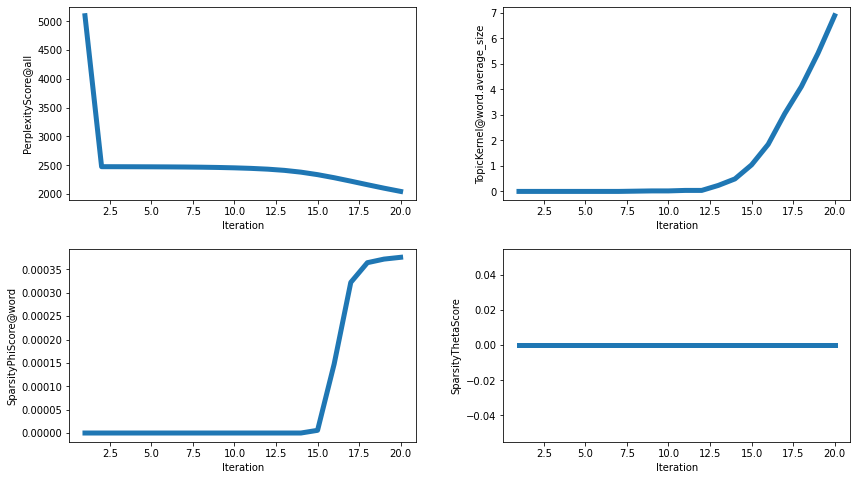

In [ ]:
draw_plots(best_model)

In [ ]:
del smoothing_regularizer_parameters
del smoothing_cube

del models
del best_model

### Model Quality Estimation<a id="model-quality-estimation"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here goes the core part: we are going to train many models and estimate their quality using topic bank.

In [ ]:
DEFAULT_SEED = 0
NUM_TOPICS = 100
NUM_FIT_ITERATIONS = 100  # with big datasets — better change this to something lower

DEFAULT_SEEDS = [0, 1, 2]

In [ ]:
ESTIMATES = QualityEstimates()

In [ ]:
ESTIMATES._save_file_path

'./Post_Science__internals/quality_estimates.json'

#### PLSA<a id="estimation-plsa"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Starting with PLSA model

In [ ]:
%%time

plsa_quality = ESTIMATES.train_models_and_estimate_quality(
    'plsa',
    default_train_func,
)

100%|██████████| 3/3 [07:49<00:00, 156.65s/it]
CPU times: user 27min 52s, sys: 1min 6s, total: 28min 59s
Wall time: 7min 49s


Several entries: one per seed (seed determines model initialization) 

In [ ]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2'])

#### Regularized 1<a id="estimation-regularized1"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
reqularized_quality = ESTIMATES.train_models_and_estimate_quality(
    'regularized',
    lambda dataset, model_number, num_topics, num_fit_iterations: regularization_train_func(
        dataset, model_number, num_topics, num_fit_iterations,
        decorrelating_tau=DECORRELATION_TAU,
        sparsing_tau=SPARSING_TAU,
    ),
)

100%|██████████| 3/3 [12:49<00:00, 256.39s/it]


In [ ]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2'])

#### Background Topics<a id="estimation-background"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
background_topics_quality = ESTIMATES.train_models_and_estimate_quality(
    'background_topics',
    lambda dataset, model_number, num_topics, num_fit_iterations: background_topics_train_func(
        dataset, model_number, num_topics, num_fit_iterations,
        smoothing_tau=SMOOTHING_TAU,
    ),
)

100%|██████████| 3/3 [16:48<00:00, 336.30s/it]


In [ ]:
background_topics_quality.keys()

dict_keys(['background_topics_0', 'background_topics_1', 'background_topics_2'])

#### Arora & CDC<a id="estimation-arora-and-cdc"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In experiments, parameter `NROWS` was chosen for each dataset in such a way so as the length of text fragment for Arora and CDC methods was between $5\,000$ and $12\,000$ words.
If one takes more text, methods will be very slow (especially CDC).
And in general, it seems that a reasonable piece of text is enough.

In [ ]:
NROWS = 15  # one should find the value for each dataset!

In [ ]:
SUBSAMPLE_NUMBER = 0  # 0 # 1 # 2

if KEEP_DATASET_IN_MEMORY:
    data_subsample = pd.read_csv(DATASET_FILE_PATH).sample(
        frac=1, random_state=42
    )
else:
     data_subsample = pd.read_csv(DATASET_FILE_PATH, nrows=5 * NROWS).sample(
         frac=1, random_state=42
     )

data_subsample = data_subsample.iloc[
    SUBSAMPLE_NUMBER * NROWS : SUBSAMPLE_NUMBER * NROWS + NROWS
]

In [ ]:
data_subsample.shape

(15, 3)

In [ ]:
data_subsample.head()

,id,raw_text,vw_text
443,34557.txt,обнаруживать самый яркий нейтронный звезда пре...,34557.txt |@word обнаруживать самый яркий нейт...
51,38347.txt,полимер биополимер химик артем оган структура ...,38347.txt |@word полимер биополимер химик арте...
794,21275.txt,введение риторика филолог гасан гусейнов искус...,21275.txt |@word введение риторика филолог гас...
1572,7218.txt,святочный гадание фольклорист варвара добровол...,7218.txt |@word святочный гадание фольклорист ...
1437,42548.txt,центральный банк задача функция факт деятельно...,42548.txt |@word центральный банк задача функц...


In [ ]:
SMALL_DATASET_FILE_PATH = os.path.join(
    DATA_FOLDER_PATH,
    f'{DATASET_NAME.value}_{NROWS}.csv',
)

In [ ]:
SMALL_DATASET_FILE_PATH

'data/Post_Science_15.csv'

In [ ]:
data_subsample.to_csv(SMALL_DATASET_FILE_PATH, index=False)

del data_subsample

In [ ]:
DATASET_INTERNALS_FOLDER_PATH

'./Post_Science__internals'

In [ ]:
SMALL_DATASET_INTERNALS_FOLDER_PATH = f'{DATASET_NAME.value}_{NROWS}__internals'

In [ ]:
SMALL_DATASET_INTERNALS_FOLDER_PATH

'Post_Science_15__internals'

Small dataset will be used by Arora and CDC

In [ ]:
SMALL_DATASET = Dataset(
    SMALL_DATASET_FILE_PATH,
    internals_folder_path=SMALL_DATASET_INTERNALS_FOLDER_PATH,
    keep_in_memory=True,  # this one should be True! it is a small dataset afterall :)
)

../../topicnet/cooking_machine/dataset.py:525: UserWarning: Attempted to use batches for different dataset.Overwriting batches in Post_Science_15__internals/batches
  warnings.warn(W_DIFF_BATCHES_1 + W_DIFF_BATCHES_2.format(self._batches_folder_path))


Checking the length of text

In [ ]:
sum(SMALL_DATASET._data['vw_text'].apply(lambda t: len(t.split())))

8346

In [ ]:
SMALL_DATASET._data.shape

(15, 3)

In [ ]:
SMALL_DATASET._data.head()

,id,raw_text,vw_text
id,,,
34557.txt,34557.txt,обнаруживать самый яркий нейтронный звезда пре...,34557.txt |@word обнаруживать самый яркий нейт...
38347.txt,38347.txt,полимер биополимер химик артем оган структура ...,38347.txt |@word полимер биополимер химик арте...
21275.txt,21275.txt,введение риторика филолог гасан гусейнов искус...,21275.txt |@word введение риторика филолог гас...
7218.txt,7218.txt,святочный гадание фольклорист варвара добровол...,7218.txt |@word святочный гадание фольклорист ...
42548.txt,42548.txt,центральный банк задача функция факт деятельно...,42548.txt |@word центральный банк задача функц...


In [ ]:
SMALL_DATASET._modalities

{'@word'}

In [ ]:
# Attention! Currently this dirty fix is needed to make things work fine
# (without it everything would also work, but better do it)

SMALL_DATASET._data['raw_text'] = SMALL_DATASET._data['vw_text']

In [ ]:
SMALL_DATASET._data.head()

,id,raw_text,vw_text
id,,,
12511.txt,12511.txt,12511.txt |@word faq добиологический эволюция ...,12511.txt |@word faq добиологический эволюция ...
51180.txt,51180.txt,51180.txt |@word советский бавария историк але...,51180.txt |@word советский бавария историк але...
43669.txt,43669.txt,43669.txt |@word психология решение личностный...,43669.txt |@word психология решение личностный...
6673.txt,6673.txt,6673.txt |@word инфракрасный небо физик анатол...,6673.txt |@word инфракрасный небо физик анатол...
31895.txt,31895.txt,31895.txt |@word faq dбраны мтеория факт теори...,31895.txt |@word faq dбраны мтеория факт теори...


In [ ]:
%%time

ARORA_PHI = arora_compute_phi(
    SMALL_DATASET, main_modality=MAIN_MODALITY, num_topics=NUM_TOPICS
)

CPU times: user 3min 55s, sys: 4min 6s, total: 8min 2s
Wall time: 23.3 s


In [ ]:
ARORA_PHI.shape

(3392, 100)

In [ ]:
ARORA_PHI.head()

arora_topic_0  arora_topic_1  arora_topic_2  \
modality token                                                          
@word    духовность        3.925962e-09   2.875406e-09   3.142523e-08   
         нейрологический   3.925962e-09   2.875406e-09   3.142523e-08   
         добывать          3.925962e-09   2.875406e-09   3.142523e-08   
         суждение          3.925962e-09   2.875406e-09   3.142523e-08   
         моральный         3.862271e-09   3.403493e-09   2.804863e-08   

                          arora_topic_3  arora_topic_4  arora_topic_5  \
modality token                                                          
@word    духовность        2.422083e-10   3.080308e-09       0.004700   
         нейрологический   2.422083e-10   3.080308e-09       0.004700   
         добывать          2.422083e-10   3.080308e-09       0.004700   
         суждение          2.422083e-10   3.080308e-09       0.004700   
         моральный         4.415990e-10   3.471230e-09       0.004755   

                          arora_topic_6  arora_topic_7  arora_topic_8  \
modality token                                                          
@word    духовность        5.679448e-09   2.050247e-10   4.044835e-09   
         нейрологический   5.679448e-09   2.050247e-10   4.044835e-09   
         добывать          5.679448e-09   2.050247e-10   4.044835e-09   
         суждение          5.679448e-09   2.050247e-10   4.044835e-09   
         моральный         5.874747e-09   3.946931e-10   4.398618e-09   

                          arora_topic_9  ...  arora_topic_90  arora_topic_91  \
modality token                           ...                                   
@word    духовность        4.232480e-09  ...    3.236685e-08    4.861015e-08   
         нейрологический   4.232480e-09  ...    3.236685e-08    4.861015e-08   
         добывать          4.232480e-09  ...    3.236685e-08    4.861015e-08   
         суждение          4.232480e-09  ...    3.236685e-08    4.861015e-08   
         моральный         4.597704e-09  ...    2.933476e-08    4.470580e-08   

                          arora_topic_92  arora_topic_93  arora_topic_94  \
modality token                                                             
@word    духовность         4.861015e-08        0.000014        0.000014   
         нейрологический    4.861015e-08        0.000014        0.000014   
         добывать           4.861015e-08        0.000014        0.000014   
         суждение           4.861015e-08        0.000014        0.000014   
         моральный          4.470580e-08        0.000007        0.000007   

                          arora_topic_95  arora_topic_96  arora_topic_97  \
modality token                                                             
@word    духовность         4.554806e-08        0.000014    4.581575e-08   
         нейрологический    4.554806e-08        0.000014    4.581575e-08   
         добывать           4.554806e-08        0.000014    4.581575e-08   
         суждение           4.554806e-08        0.000014    4.581575e-08   
         моральный          4.175946e-08        0.000007    4.185474e-08   

                          arora_topic_98  arora_topic_99  
modality token                                            
@word    духовность             0.000009    1.156760e-06  
         нейрологический        0.000009    1.156760e-06  
         добывать               0.000009    1.156760e-06  
         суждение               0.000009    1.156760e-06  
         моральный              0.000005    7.338795e-07  

[5 rows x 100 columns]

In [ ]:
ARORA_PHI['arora_topic_9'].sort_values(ascending=False)[:10]

modality  token       
@word     звезда          0.044847
          термоядерный    0.018668
          нейтронный      0.016973
          энергия         0.015291
          реакция         0.015278
          солнце          0.014435
          вспышка         0.014430
          вещество        0.013589
          объект          0.011858
          видеть          0.011048
Name: arora_topic_9, dtype: float64

We will consider a topic found by Arora or CDC as bad if this topic's $10$ top token probabilities are the same.

In [ ]:
good_topics = list()

for t in ARORA_PHI.columns:
    vals = ARORA_PHI.loc[:, t].sort_values(ascending=False)[:10]
    
    if all(v == vals[0] for v in vals[1:]):
        continue
        
    good_topics.append(t)

In [ ]:
len(good_topics)  # for Arora always all topics appeared to be good

100

In [ ]:
ARORA_PHI = ARORA_PHI.loc[:, good_topics]

In [ ]:
ARORA_PHI = ARORA_PHI.loc[MODALITIES_OF_INTEREST]

In [ ]:
ARORA_PHI.shape

(3392, 100)

And here we need vocabulary which we collected quite enough cells earlier.

In [ ]:
COMMON_WORDS = list(
    set(KNOWN_WORDS).intersection(ARORA_PHI.index.get_level_values(1))
)

In [ ]:
len(COMMON_WORDS)

2234

In [ ]:
ARORA_PHI = ARORA_PHI.loc[[(MAIN_MODALITY, w) for w in COMMON_WORDS], :]

In [ ]:
ARORA_PHI.shape

(2234, 100)

In [ ]:
ARORA_PHI.iloc[:, 10].sort_values(ascending=False)[:10]

modality  token          
@word     общество           0.042788
          социальный         0.027477
          социология         0.021032
          социологический    0.014569
          мир                0.009713
          понятие            0.008083
          теория             0.008077
          ни                 0.007284
          объект             0.007272
          категория          0.006483
Name: arora_topic_10, dtype: float64

In experiments, `min_samples` was varied to make number of good topics (calculated below) roughly equal to $100$.

In [ ]:
%%time

CDC_PHI = cdc_compute_phi(SMALL_DATASET, main_modality=MAIN_MODALITY, min_samples=7)

CPU times: user 1min 24s, sys: 0 ns, total: 1min 24s
Wall time: 1min 23s


In [ ]:
CDC_PHI.shape

(3392, 96)

In [ ]:
CDC_PHI.head()

cdc_topic_0  cdc_topic_1  cdc_topic_2  cdc_topic_3  \
modality token                                                                 
@word    духовность          0.000999     0.000999     0.000999     0.000999   
         нейрологический     0.000999     0.000999     0.000999     0.000999   
         добывать            0.000999     0.000999     0.000999     0.000999   
         суждение            0.000999     0.000999     0.000999     0.000999   
         моральный           0.000999     0.000999     0.000999     0.000999   

                          cdc_topic_4  cdc_topic_5  cdc_topic_6  cdc_topic_7  \
modality token                                                                 
@word    духовность          0.000999     0.000999     0.000999     0.000999   
         нейрологический     0.000999     0.000999     0.000999     0.000999   
         добывать            0.000999     0.000999     0.000999     0.000999   
         суждение            0.000999     0.000999     0.000999     0.000999   
         моральный           0.000999     0.000999     0.000999     0.000999   

                          cdc_topic_8  cdc_topic_9  ...  cdc_topic_86  \
modality token                                      ...                 
@word    духовность          0.000999     0.000999  ...      0.000999   
         нейрологический     0.000999     0.000999  ...      0.000999   
         добывать            0.000999     0.000999  ...      0.000999   
         суждение            0.000999     0.000999  ...      0.000999   
         моральный           0.000999     0.000999  ...      0.000999   

                          cdc_topic_87  cdc_topic_88  cdc_topic_89  \
modality token                                                       
@word    духовность           0.000999      0.000999      0.000999   
         нейрологический      0.000999      0.000999      0.000999   
         добывать             0.000999      0.000999      0.000999   
         суждение             0.000999      0.000999      0.000999   
         моральный            0.000999      0.000999      0.000999   

                          cdc_topic_90  cdc_topic_91  cdc_topic_92  \
modality token                                                       
@word    духовность           0.000999      0.000999      0.000999   
         нейрологический      0.000999      0.000999      0.000999   
         добывать             0.000999      0.000999      0.000999   
         суждение             0.000999      0.000999      0.000999   
         моральный            0.000999      0.000999      0.000999   

                          cdc_topic_93  cdc_topic_94  cdc_topic_95  
modality token                                                      
@word    духовность           0.000999      0.000999      0.000999  
         нейрологический      0.000999      0.000999      0.000999  
         добывать             0.000999      0.000999      0.000999  
         суждение             0.000999      0.000999      0.000999  
         моральный            0.000999      0.000999      0.000999  

[5 rows x 96 columns]

In [ ]:
good_topics = list()

for t in CDC_PHI.columns:
    vals = CDC_PHI.loc[:, t].sort_values(ascending=False)[:10]
    
    if all(v == vals[0] for v in vals[1:]):
        continue
        
    good_topics.append(t)

In [ ]:
len(good_topics)  # but for CDC there were always (some) bad topics

96

In [ ]:
CDC_PHI = CDC_PHI.loc[:, good_topics]

In [ ]:
CDC_PHI.shape

(3392, 96)

In [ ]:
CDC_PHI.iloc[:, 39].sort_values(ascending=False)[:10]

modality  token         
@word     рассчитываться    1.000000
          страховой         0.900100
          перспектива       0.700300
          сохранение        0.600400
          формула           0.433522
          формироваться     0.350325
          обязательный      0.250375
          компонент         0.208498
          изменение         0.151644
          встречать         0.150425
Name: cdc_topic_39, dtype: float64

In [ ]:
CDC_PHI = CDC_PHI.loc[MODALITIES_OF_INTEREST]

In [ ]:
CDC_PHI.shape

(3392, 96)

In [ ]:
CDC_PHI.head()

cdc_topic_0  cdc_topic_1  cdc_topic_2  cdc_topic_3  \
modality token                                                                 
@word    духовность          0.000999     0.000999     0.000999     0.000999   
         нейрологический     0.000999     0.000999     0.000999     0.000999   
         добывать            0.000999     0.000999     0.000999     0.000999   
         суждение            0.000999     0.000999     0.000999     0.000999   
         моральный           0.000999     0.000999     0.000999     0.000999   

                          cdc_topic_4  cdc_topic_5  cdc_topic_6  cdc_topic_7  \
modality token                                                                 
@word    духовность          0.000999     0.000999     0.000999     0.000999   
         нейрологический     0.000999     0.000999     0.000999     0.000999   
         добывать            0.000999     0.000999     0.000999     0.000999   
         суждение            0.000999     0.000999     0.000999     0.000999   
         моральный           0.000999     0.000999     0.000999     0.000999   

                          cdc_topic_8  cdc_topic_9  ...  cdc_topic_86  \
modality token                                      ...                 
@word    духовность          0.000999     0.000999  ...      0.000999   
         нейрологический     0.000999     0.000999  ...      0.000999   
         добывать            0.000999     0.000999  ...      0.000999   
         суждение            0.000999     0.000999  ...      0.000999   
         моральный           0.000999     0.000999  ...      0.000999   

                          cdc_topic_87  cdc_topic_88  cdc_topic_89  \
modality token                                                       
@word    духовность           0.000999      0.000999      0.000999   
         нейрологический      0.000999      0.000999      0.000999   
         добывать             0.000999      0.000999      0.000999   
         суждение             0.000999      0.000999      0.000999   
         моральный            0.000999      0.000999      0.000999   

                          cdc_topic_90  cdc_topic_91  cdc_topic_92  \
modality token                                                       
@word    духовность           0.000999      0.000999      0.000999   
         нейрологический      0.000999      0.000999      0.000999   
         добывать             0.000999      0.000999      0.000999   
         суждение             0.000999      0.000999      0.000999   
         моральный            0.000999      0.000999      0.000999   

                          cdc_topic_93  cdc_topic_94  cdc_topic_95  
modality token                                                      
@word    духовность           0.000999      0.000999      0.000999  
         нейрологический      0.000999      0.000999      0.000999  
         добывать             0.000999      0.000999      0.000999  
         суждение             0.000999      0.000999      0.000999  
         моральный            0.000999      0.000999      0.000999  

[5 rows x 96 columns]

In [ ]:
COMMON_WORDS = list(
    set(KNOWN_WORDS).intersection(CDC_PHI.index.get_level_values(1))
)

In [ ]:
len(COMMON_WORDS)

2234

In [ ]:
CDC_PHI = CDC_PHI.loc[[(MAIN_MODALITY, w) for w in COMMON_WORDS], :]

In [ ]:
CDC_PHI.shape

(2234, 96)

In [ ]:
%%time

for external_phi, method_name in zip([ARORA_PHI, CDC_PHI], ['arora', 'cdc']):
    num_topics_to_copy = min(NUM_TOPICS, external_phi.shape[1])

    print('Num topics to copy:', num_topics_to_copy)
    
    def initialize_phi_func(dataset, model_number, num_topics):
        return initialize_with_copying_topics(
            dataset=dataset,
            model_number=model_number,
            num_topics=num_topics,
            phi=external_phi,
            num_topics_to_copy=num_topics_to_copy,
        )

    arora_quality = ESTIMATES.train_models_and_estimate_quality(
        f'{method_name}__{NROWS}_{SUBSAMPLE_NUMBER}',
        lambda dataset, model_number, num_topics, num_fit_iterations: specific_initial_phi_train_func(
            dataset=dataset,
            model_number=model_number,
            num_topics=num_topics,
            num_fit_iterations=num_fit_iterations,
            initialize_phi_func=initialize_phi_func,
        ),
    )

100%|██████████| 3/3 [07:53<00:00, 157.73s/it]
CPU times: user 27min 34s, sys: 57.2 s, total: 28min 31s
Wall time: 7min 53s


In [ ]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'arora_0', 'arora_1', 'arora_2', 'cdc_0', 'cdc_1', 'cdc_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'arora__10_0_0', 'arora__10_0_1', 'arora__10_0_2', 'cdc__10_0_0', 'cdc__10_0_1', 'cdc__10_0_2', 'arora__8_1_0', 'arora__8_1_1', 'arora__8_1_2', 'cdc__8_1_0', 'cdc__8_1_1', 'cdc__8_1_2', 'arora__8_2_0', 'arora__8_2_1', 'arora__8_2_2', 'cdc__8_2_0', 'cdc__8_2_1', 'cdc__8_2_2'])

#### LDA, Sparse, Decorrelation & Regularized 2<a id="estimation-lda-and-all-all-all"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

And a pair of other models

In [ ]:
def train_model_from_family(
        model_family, dataset, model_number, num_topics, num_fit_iterations) -> TopicModel:

    artm_model = init_model_from_family(
        family=model_family,
        dataset=dataset,
        main_modality=MAIN_MODALITY,
        num_topics=num_topics,
        seed=model_number,
    )

    artm_model.fit_offline(dataset.get_batch_vectorizer(), num_fit_iterations)

    return TopicModel(artm_model)

In [ ]:
%%time

for model_family in [
    KnownModel.LDA,
    KnownModel.SPARSE,
    KnownModel.DECORRELATION,
    KnownModel.ARTM,
]:
    print(model_family)
    
    family_quality = ESTIMATES.train_models_and_estimate_quality(
        model_family.value.lower(),
        lambda dataset, model_number, num_topics, num_fit_iterations: train_model_from_family(
            model_family=model_family,
            dataset=dataset,
            model_number=model_number,
            num_topics=num_topics,
            num_fit_iterations=num_fit_iterations,
        ),
    )

KnownModel.LDA
100%|██████████| 3/3 [14:49<00:00, 296.42s/it]
KnownModel.SPARSE
100%|██████████| 3/3 [15:00<00:00, 300.16s/it]
KnownModel.DECORRELATION
100%|██████████| 3/3 [14:42<00:00, 294.29s/it]
KnownModel.ARTM
100%|██████████| 3/3 [15:01<00:00, 300.43s/it]
CPU times: user 2h 58min 25s, sys: 21 s, total: 2h 58min 46s
Wall time: 59min 33s


#### Topic Selection & Decorrelation. All at Once but One after Another<a id="estimation-selection-plus-decorrelation1"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

And a few models with Topic Selection regularizer

In [ ]:
if KEEP_DATASET_IN_MEMORY:
    NUM_CUBE_ITERATIONS = 33
else:
    NUM_CUBE_ITERATIONS = 5

In [ ]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return DECORRELATION_TAU
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return 0.0
    elif cur_iter <= 2 * NUM_CUBE_ITERATIONS:
        return SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter > 2 * NUM_CUBE_ITERATIONS: 
        return SPARSING_TAU
    else:
        return 0.0

In [ ]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]


cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False,
)

In [ ]:
topic_model = initialize_topic_model()

In [ ]:
%%time

models = cube(topic_model, DATASET)

CPU times: user 7min 5s, sys: 1.97 s, total: 7min 7s
Wall time: 6min 39s


In [ ]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__21-34-55)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [ ]:
best_model

Model(id=--21h34m56s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__21-34-55)

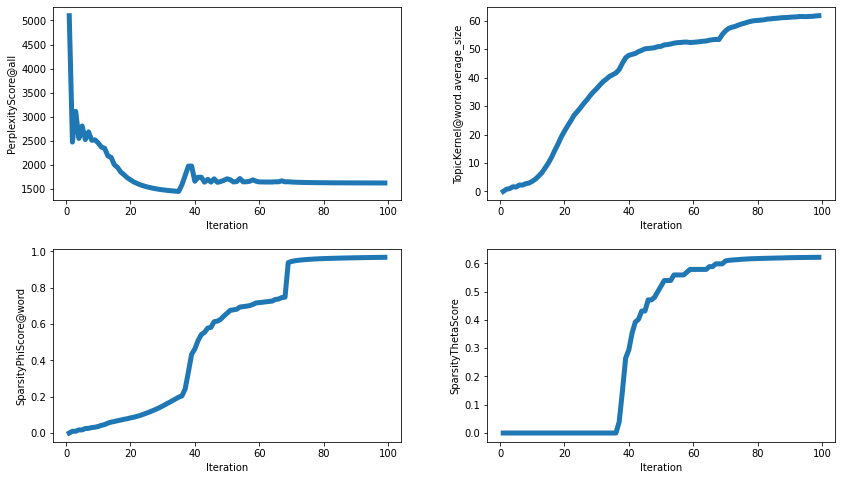

In [ ]:
draw_plots(best_model)

In [ ]:
model_quality = ESTIMATES._estimate_model_quality(best_model)

In [ ]:
ESTIMATES.update({ 'soph_aooa': model_quality })

In [ ]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'arora_0', 'arora_1', 'arora_2', 'cdc__250_1_0', 'cdc__250_1_1', 'cdc__250_1_2', 'cdc__250_2_0', 'cdc__250_2_1', 'cdc__250_2_2', 'cdc__250_3_0', 'cdc__250_3_1', 'cdc__250_3_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa'])

In [ ]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

#### Topic Selection & Decorrelation. Changing Parameters<a id="estimation-selection-plus-decorrelation2"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return cur_iter / NUM_CUBE_ITERATIONS * DECORRELATION_TAU
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return 0.0
    elif cur_iter <= 2 * NUM_CUBE_ITERATIONS:
        return (cur_iter - NUM_CUBE_ITERATIONS) / NUM_CUBE_ITERATIONS * SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter > 2 * NUM_CUBE_ITERATIONS: 
        return (cur_iter - 2 * NUM_CUBE_ITERATIONS) / NUM_CUBE_ITERATIONS * SPARSING_TAU
    else:
        return 0.0

In [ ]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]

cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False,
)

In [ ]:
topic_model = initialize_topic_model()

In [ ]:
%%time

models = cube(topic_model, DATASET)

CPU times: user 6min 54s, sys: 1.88 s, total: 6min 56s
Wall time: 6min 23s


In [ ]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__21-41-36)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [ ]:
best_model

Model(id=--21h41m37s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__21-41-36)

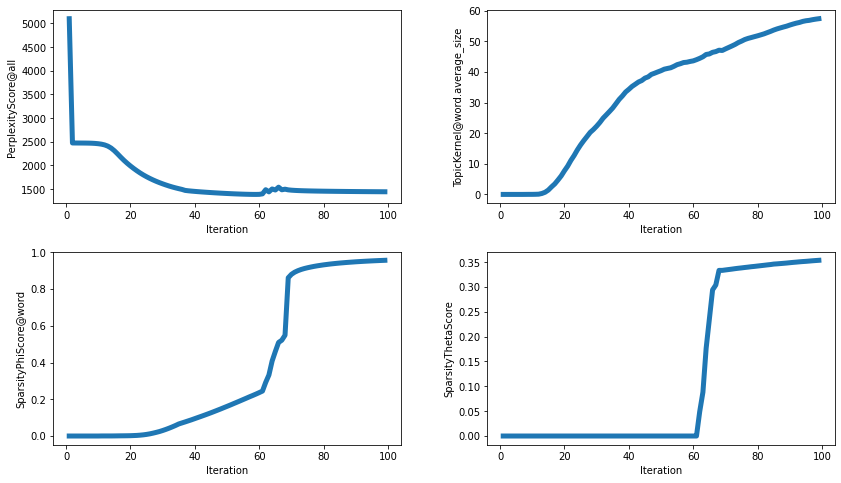

In [ ]:
draw_plots(best_model)

In [ ]:
model_quality = ESTIMATES._estimate_model_quality(best_model)

In [ ]:
ESTIMATES.update({'soph_cp': model_quality})

In [ ]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

#### Topic Selection & Decorrelation. Alternating Order<a id="estimation-selection-plus-decorrelation3"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        if cur_iter % 2 == 1:
            return DECORRELATION_TAU
        else:
            return 0.0
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return 0.0
    elif cur_iter <= 2 * NUM_CUBE_ITERATIONS:
        if cur_iter % 2 == 1:
            return 0.0
        else:
            return SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter > 2 * NUM_CUBE_ITERATIONS: 
        return SPARSING_TAU
    else:
        return 0.0

In [ ]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]

cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False,
)

In [ ]:
topic_model = initialize_topic_model()

In [ ]:
%%time

models = cube(topic_model, DATASET)

CPU times: user 7min 7s, sys: 2.67 s, total: 7min 10s
Wall time: 6min 30s


In [ ]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__21-48-02)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [ ]:
best_model

Model(id=--21h48m03s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__21-48-02)

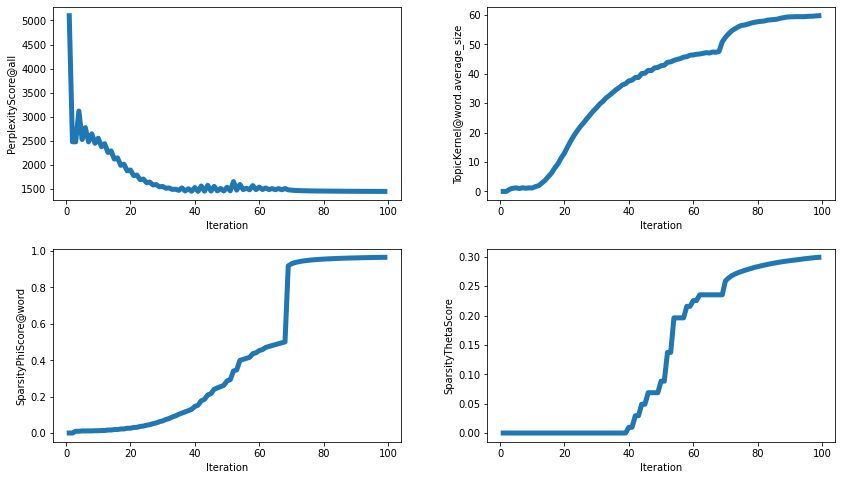

In [ ]:
draw_plots(best_model)

In [ ]:
model_quality = ESTIMATES._estimate_model_quality(best_model)

In [ ]:
ESTIMATES.update({'soph_ao': model_quality})

In [ ]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'arora_0', 'arora_1', 'arora_2', 'cdc_0', 'cdc_1', 'cdc_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao'])

In [ ]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

#### Topic Selection & Decorrelation. Alternating Order & Changing Parameters<a id="estimation-selection-plus-decorrelation4"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    end_iteration = 2 * NUM_CUBE_ITERATIONS

    if cur_iter <= end_iteration:
        if cur_iter % 2 == 1:
            return max(1, cur_iter / NUM_CUBE_ITERATIONS) * DECORRELATION_TAU
        else:
            return 0.0
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    start_iteration = NUM_CUBE_ITERATIONS // 4  # after some time since decorrelation started
    end_iteration = 2 * NUM_CUBE_ITERATIONS + 3 * NUM_CUBE_ITERATIONS // 4

    if cur_iter <= start_iteration:
        return 0.0
    elif cur_iter <= end_iteration:
        if cur_iter % 2 == 1:
            return 0.0
        else:
            return max(1, (cur_iter - start_iteration) / NUM_CUBE_ITERATIONS) * SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    start_iteration = 2 * NUM_CUBE_ITERATIONS

    if cur_iter > start_iteration: 
        return max(1, (cur_iter - start_iteration) / NUM_CUBE_ITERATIONS) * SPARSING_TAU
    else:
        return 0.0

In [ ]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]

cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False,
)

In [ ]:
topic_model = initialize_topic_model()

In [ ]:
%%time

models = cube(topic_model, DATASET)

CPU times: user 7min 20s, sys: 3.08 s, total: 7min 23s
Wall time: 6min 36s


In [ ]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-12__21-54-35)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
/home/vasiliyalekseev/miniconda/envs/topnum/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [ ]:
best_model

Model(id=--21h54m36s_12d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-12__21-54-35)

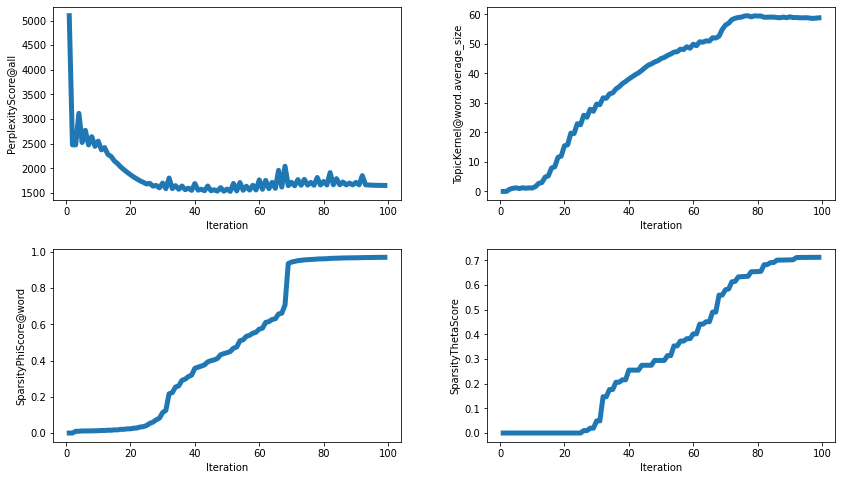

In [ ]:
draw_plots(best_model)

In [ ]:
model_quality = ESTIMATES._estimate_model_quality(
    best_model,
)

In [ ]:
ESTIMATES.update({'soph_aocp': model_quality})

In [ ]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'arora__100_1_0', 'arora__100_1_1', 'arora__100_1_2', 'cdc__100_1_0', 'cdc__100_1_1', 'cdc__100_1_2', 'arora__100_2_0', 'arora__100_2_1', 'arora__100_2_2', 'cdc__100_2_0', 'cdc__100_2_1', 'cdc__100_2_2', 'arora__100_3_0', 'arora__100_3_1', 'arora__100_3_2', 'cdc__100_3_0', 'cdc__100_3_1', 'cdc__100_3_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp'])

This is it! Below we make plots to look at what we have

## Results<a id="results"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Loading calculated quality estimates

In [ ]:
ESTIMATES = dict()

for dataset_folder_name in DatasetName:
    estimates_file_path = os.path.join(
        get_dataset_internals_folder_path(dataset_folder_name),
        'quality_estimates.json',
    )

    ESTIMATES[dataset_folder_name] = json.loads(
        open(estimates_file_path, 'r').read()
    )

In [ ]:
SAMPLE_DATASET_NAME = DatasetName.POSTNAUKA

In [ ]:
ESTIMATES[SAMPLE_DATASET_NAME].keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'arora__20_0_0', 'arora__20_0_1', 'arora__20_0_2', 'cdc__20_0_0', 'cdc__20_0_1', 'cdc__20_0_2', 'arora__15_1_0', 'arora__15_1_1', 'arora__15_1_2', 'cdc__15_1_0', 'cdc__15_1_1', 'cdc__15_1_2', 'arora__15_2_0', 'arora__15_2_1', 'arora__15_2_2', 'cdc__15_2_0', 'cdc__15_2_1', 'cdc__15_2_2'])

### Fixing Keys<a id="results-fixing-keys"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

It turned out, that threshold keys were... not so-human-friendly.
Let's fix it

In [ ]:
ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0'].keys()

dict_keys(['0.1', '0.15000000000000002', '0.20000000000000004', '0.25000000000000006', '0.30000000000000004', '0.3500000000000001', '0.40000000000000013', '0.45000000000000007', '0.5000000000000001', '0.5500000000000002', '0.6000000000000002', '0.6500000000000001', '0.7000000000000002', '0.7500000000000002', '0.8000000000000002', '0.8500000000000002', '0.9000000000000002'])

In [ ]:
ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0']['0.1'].keys()

dict_keys(['num_good_topics', 'num_found_topics', 'found_topics', 'coherence@bank', 'precision@bank', 'recall@bank', 'cost', '_num_model_topics', '_num_bank_topics'])

In [ ]:
def fix_key(key: str) -> float:
    return int(float(key) * 100) / 100

In [ ]:
fix_key('0.1')

0.1

In [ ]:
new_estimates = dict()

for dataset_folder_name in DatasetName:
    new_dataset_estimates = dict()
    dataset_estimates = ESTIMATES[dataset_folder_name]

    for model, threshold_metrics in dataset_estimates.items():
        new_threshold_metrics = dict()

        for threshold, metrics in threshold_metrics.items():
            new_threshold_metrics[fix_key(threshold)] = copy.deepcopy(metrics)

        new_dataset_estimates[model] = new_threshold_metrics
    
    new_estimates[dataset_folder_name] = new_dataset_estimates

In [ ]:
new_estimates[SAMPLE_DATASET_NAME].keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'arora__20_0_0', 'arora__20_0_1', 'arora__20_0_2', 'cdc__20_0_0', 'cdc__20_0_1', 'cdc__20_0_2', 'arora__15_1_0', 'arora__15_1_1', 'arora__15_1_2', 'cdc__15_1_0', 'cdc__15_1_1', 'cdc__15_1_2', 'arora__15_2_0', 'arora__15_2_1', 'arora__15_2_2', 'cdc__15_2_0', 'cdc__15_2_1', 'cdc__15_2_2'])

In [ ]:
new_estimates[SAMPLE_DATASET_NAME]['plsa_0'].keys()

dict_keys([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])

In [ ]:
ESTIMATES = new_estimates

In [ ]:
ESTIMATES.keys()

dict_keys([<DatasetName.POSTNAUKA: 'Post_Science'>, <DatasetName.REUTERS: 'Reuters'>, <DatasetName.BROWN: 'Brown'>, <DatasetName.TWENTY_NEWSGROUPS: '20NG_natural_order'>, <DatasetName.AG_NEWS: 'AG_News'>, <DatasetName.WATAN: 'Watan2004'>, <DatasetName.HABRAHABR: 'Habrahabr'>])

### Averaging<a id="results-averaging"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here we are averaging estimates corresponding to different seeds

In [ ]:
ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0'].keys()

dict_keys([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])

In [ ]:
ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0'][0.45]

{'num_good_topics': 6,
 'num_found_topics': 6,
 'found_topics': ['topic_15',
  'topic_9',
  'topic_3',
  'topic_5',
  'topic_14',
  'topic_8'],
 'coherence@bank': 0.06,
 'precision@bank': 0.06,
 'recall@bank': 0.25,
 'cost': 15.407293319702148,
 '_num_model_topics': 100,
 '_num_bank_topics': 24}

In [ ]:
def compute_coherence_at_bank(metrics: dict) -> float:
    return metrics[KEY_NUM_GOOD_TOPICS] / max(1, metrics[_KEY_NUM_MODEL_TOPICS])

def compute_precision_at_bank(metrics: dict) -> float:
    return metrics[KEY_NUM_FOUND_TOPICS] / max(1, metrics[_KEY_NUM_MODEL_TOPICS])

def compute_recall_at_bank(metrics: dict) -> float:
    return metrics[KEY_NUM_FOUND_TOPICS] / max(1, metrics[_KEY_NUM_BANK_TOPICS])

In [ ]:
sample_data = copy.deepcopy(ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0'][0.45])

In [ ]:
sample_data

{'num_good_topics': 6,
 'num_found_topics': 6,
 'found_topics': ['topic_15',
  'topic_9',
  'topic_3',
  'topic_5',
  'topic_14',
  'topic_8'],
 'coherence@bank': 0.06,
 'precision@bank': 0.06,
 'recall@bank': 0.25,
 'cost': 15.407293319702148,
 '_num_model_topics': 100,
 '_num_bank_topics': 24}

In [ ]:
assert compute_coherence_at_bank(sample_data) == sample_data[KEY_COHERENCE_AT_BANK]
assert compute_precision_at_bank(sample_data) == sample_data[KEY_PRECISION_AT_BANK]
assert compute_recall_at_bank(sample_data) == sample_data[KEY_RECALL_AT_BANK]

In [ ]:
ESTIMATES[SAMPLE_DATASET_NAME].keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'arora__20_0_0', 'arora__20_0_1', 'arora__20_0_2', 'cdc__20_0_0', 'cdc__20_0_1', 'cdc__20_0_2', 'arora__15_1_0', 'arora__15_1_1', 'arora__15_1_2', 'cdc__15_1_0', 'cdc__15_1_1', 'cdc__15_1_2', 'arora__15_2_0', 'arora__15_2_1', 'arora__15_2_2', 'cdc__15_2_0', 'cdc__15_2_1', 'cdc__15_2_2'])

In [ ]:
def average_for_model(dataset_estimates, source_names: List[str]) -> dict:
    if len(source_names) == 0:
        raise ValueError()

    result_metrics = dict()

    for threshold in dataset_estimates[source_names[0]]:
        metrics_for_threshold = dict()

        
        for k in [KEY_NUM_GOOD_TOPICS, KEY_COST, KEY_NUM_FOUND_TOPICS]:
            metrics_for_threshold[k] = 0

            for n in source_names:
                metrics_for_threshold[k] += dataset_estimates[n][threshold][k]

            metrics_for_threshold[k] /= 3.0
        
        
#         metrics_for_threshold['found_topics'] = list()
        
#         for n in source_names:
#             metrics_for_threshold['found_topics'] += DATA[n][threshold]['found_topics']
        
#         metrics_for_threshold['found_topics'] = list(
#             set(metrics_for_threshold['found_topics'])
#         )
#         metrics_for_threshold['num_found_topics'] = len(metrics_for_threshold['found_topics'])
        
        
        for k in [_KEY_NUM_MODEL_TOPICS, _KEY_NUM_BANK_TOPICS]:
            assert all(
                dataset_estimates[n][threshold][k] == dataset_estimates[source_names[0]][threshold][k]
                for n in source_names[1:]
            )

            metrics_for_threshold[k] = dataset_estimates[source_names[0]][threshold][k]
        
        metrics_for_threshold[KEY_COHERENCE_AT_BANK] = compute_coherence_at_bank(
            metrics_for_threshold
        )
        metrics_for_threshold[KEY_PRECISION_AT_BANK] = compute_precision_at_bank(
            metrics_for_threshold
        )
        metrics_for_threshold[KEY_RECALL_AT_BANK] = compute_recall_at_bank(
            metrics_for_threshold
        )
        
        result_metrics[threshold] = metrics_for_threshold
    
    return result_metrics

In [ ]:
averaged = average_for_model(
    ESTIMATES[SAMPLE_DATASET_NAME],
    [f'plsa_{i}' for i in [0, 1, 2]]
)

In [ ]:
averaged[0.1]

{'num_good_topics': 0.0,
 'cost': 15.647758483886719,
 'num_found_topics': 0.0,
 '_num_model_topics': 100,
 '_num_bank_topics': 24,
 'coherence@bank': 0.0,
 'precision@bank': 0.0,
 'recall@bank': 0.0}

In [ ]:
MODEL_IDS_FOR_AVERAGING = [
    'plsa', 'regularized', 'background_topics',
    'arora', 'cdc',
    'lda',  'sparse', 'decorrelation', 'artm',
]

In [ ]:
for dataset_folder_name in DatasetName:
    dataset_estimates = ESTIMATES[dataset_folder_name]
    dataset_model_names = list(dataset_estimates.keys())

    for model_name in MODEL_IDS_FOR_AVERAGING:
        source_names = [
            n for n in dataset_model_names if n.startswith(model_name)
        ]

        dataset_estimates[model_name] = average_for_model(
            dataset_estimates, source_names
        )

        for n in source_names:
            del dataset_estimates[n]

In [ ]:
ESTIMATES[SAMPLE_DATASET_NAME].keys()

dict_keys(['soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'plsa', 'regularized', 'background_topics', 'arora', 'cdc', 'lda', 'sparse', 'decorrelation', 'artm'])

In [ ]:
MODEL_ID_TO_LABEL = {
    'arora': 'arora',
    'artm': 'regul2',
    'background_topics': 'bcg',
    'cdc': 'cdc',
    'decorrelation': 'decorr',
    'lda': 'lda',
    'plsa': 'plsa',
    'regularized': 'regul1',
    'sparse': 'sparse',
    'soph_aooa': 'sel_aooa',
    'soph_cp': 'sel_cp',
    'soph_ao': 'sel_ao',
    'soph_aocp': 'sel_aocp',
}

MODEL_IDS_ORDERED = [
    'plsa',
    'lda',
    'sparse',
    'decorrelation',
    'background_topics',
    'regularized',
    'artm',
    'arora',
    'cdc',
    'soph_aooa',
    'soph_cp',
    'soph_ao',
    'soph_aocp',
]

In [ ]:
assert all(m in MODEL_ID_TO_LABEL for m in ESTIMATES[SAMPLE_DATASET_NAME].keys())
assert sorted(MODEL_ID_TO_LABEL) == sorted(MODEL_IDS_ORDERED)

In [ ]:
THRESHOLDS = sorted(list(ESTIMATES[SAMPLE_DATASET_NAME]['plsa'].keys()))

In [ ]:
THRESHOLDS

[0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9]

The lower the threshold, the better

In [ ]:
THRESHOLD_TO_WEIGHT = {
    t: 1.0 / (t ** 2) if t <= 0.8 else 0 for t in THRESHOLDS
}

In [ ]:
THRESHOLD_TO_WEIGHT

{0.1: 99.99999999999999,
 0.15: 44.44444444444444,
 0.2: 24.999999999999996,
 0.25: 16.0,
 0.3: 11.11111111111111,
 0.35: 8.163265306122451,
 0.4: 6.249999999999999,
 0.45: 4.938271604938271,
 0.5: 4.0,
 0.55: 3.305785123966942,
 0.6: 2.7777777777777777,
 0.65: 2.3668639053254434,
 0.7: 2.0408163265306127,
 0.75: 1.7777777777777777,
 0.8: 1.5624999999999998,
 0.85: 0,
 0.9: 0}

In [ ]:
ESTIMATES[SAMPLE_DATASET_NAME]['arora'][0.1].keys()

dict_keys(['num_good_topics', 'cost', 'num_found_topics', '_num_model_topics', '_num_bank_topics', 'coherence@bank', 'precision@bank', 'recall@bank'])

In [ ]:
METRICS_TO_AVERAGE = [
    KEY_COHERENCE_AT_BANK,
    KEY_PRECISION_AT_BANK,
    KEY_RECALL_AT_BANK,
    KEY_COST,  # actually this one is the same for all thresholds
]

In [ ]:
AVERAGED_ESTIMATES = dict()

for dataset_folder_name in DatasetName:
    dataset_estimates = ESTIMATES[dataset_folder_name]
    averaged_dataset_estimates = dict()

    for m in dataset_estimates:
        averaged_dataset_estimates[m] = dict()

        for metric in METRICS_TO_AVERAGE:
            averaged_dataset_estimates[m][metric] = 0.0

            for t, w in THRESHOLD_TO_WEIGHT.items():
                if metric != KEY_COST:
                    normalization_coefficient = 1.0
                else:
                    normalization_coefficient = 1.0 / min(
                        dataset_estimates[m][t][_KEY_NUM_MODEL_TOPICS],
                        dataset_estimates[m][t][_KEY_NUM_BANK_TOPICS],
                    )

                averaged_dataset_estimates[m][metric] += (
                    dataset_estimates[m][t][metric] * normalization_coefficient * w
                )

            averaged_dataset_estimates[m][metric] = 1.0 * averaged_dataset_estimates[m][metric] / sum(
                list(THRESHOLD_TO_WEIGHT.values())
            )
            
            if metric == KEY_COST:
                averaged_dataset_estimates[m][KEY_REVERSED_COST] = (
                    1.0 / averaged_dataset_estimates[m][metric]
                )
    
    AVERAGED_ESTIMATES[dataset_folder_name] = averaged_dataset_estimates

In [ ]:
AVERAGED_ESTIMATES[SAMPLE_DATASET_NAME]['plsa']

{'coherence@bank': 0.011363751691628583,
 'precision@bank': 0.012363251406680048,
 'recall@bank': 0.05151354752783354,
 'cost': 0.6519899368286134,
 'reversed_cost': 1.533766003911295}

### Aggregating<a id="results-aggregating"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here we are aggregating results corresponding to different thresholds

In [ ]:
def aggregate_metrics(metric: str, data_for_datasets: List):
    model2value = dict()
    
    data_for_datasets = copy.deepcopy(data_for_datasets)
    
    for data in data_for_datasets:
        total_value = sum(model_metrics[metric] for model_metrics in data.values())
        
        for model, model_metrics in data.items():
            # TODO
            model_metrics[metric] = 1.0 * model_metrics[metric] / total_value
    
    models = list(data_for_datasets[0].keys())
    
    for m in models:
        model2value[m] = 0
        
        for data in data_for_datasets:
            assert sorted(list(data.keys())) == sorted(models)
            
            model2value[m] += data[m][metric]
        
        model2value[m] = 1.0 * model2value[m] / len(data_for_datasets)
    
    return model2value

In [ ]:
aggregated = aggregate_metrics(
    KEY_COHERENCE_AT_BANK,
    [AVERAGED_ESTIMATES[SAMPLE_DATASET_NAME]]
)

In [ ]:
aggregated

{'soph_aooa': 0.004583857335587732,
 'soph_cp': 0.007958521315075193,
 'soph_ao': 0.007581866727137529,
 'soph_aocp': 0.0018970900209039814,
 'plsa': 0.10483302098992209,
 'regularized': 0.029136474623440326,
 'background_topics': 0.10628634598598231,
 'arora': 0.18172494363191416,
 'cdc': 0.16469168689427127,
 'lda': 0.11932552590763092,
 'sparse': 0.0757716864610296,
 'decorrelation': 0.13439841424714485,
 'artm': 0.06181056585996005}

In [ ]:
sum(aggregated.values())  # should be approximately 1

0.9999999999999999

### Plots<a id="results-plots"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Finish line!

In [ ]:
LABEL_ROTATION_ANGLE = 45

In [ ]:
def draw_bar_plot(ax, metric: str, data_for_datasets: List):
    aggregated = aggregate_metrics(
        metric,
        data_for_datasets,
    )

    labels = [MODEL_ID_TO_LABEL[m] for m in MODEL_IDS_ORDERED]
    ticks = list(range(len(labels)))
    heights = [aggregated[m] for m in MODEL_IDS_ORDERED]

    ax.bar(ticks, heights, color='g')

    ax.set_ylabel(metric, labelpad=20)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=LABEL_ROTATION_ANGLE)
    
    ax.grid(True)
    ax.set_axisbelow(True)
    
    return ax

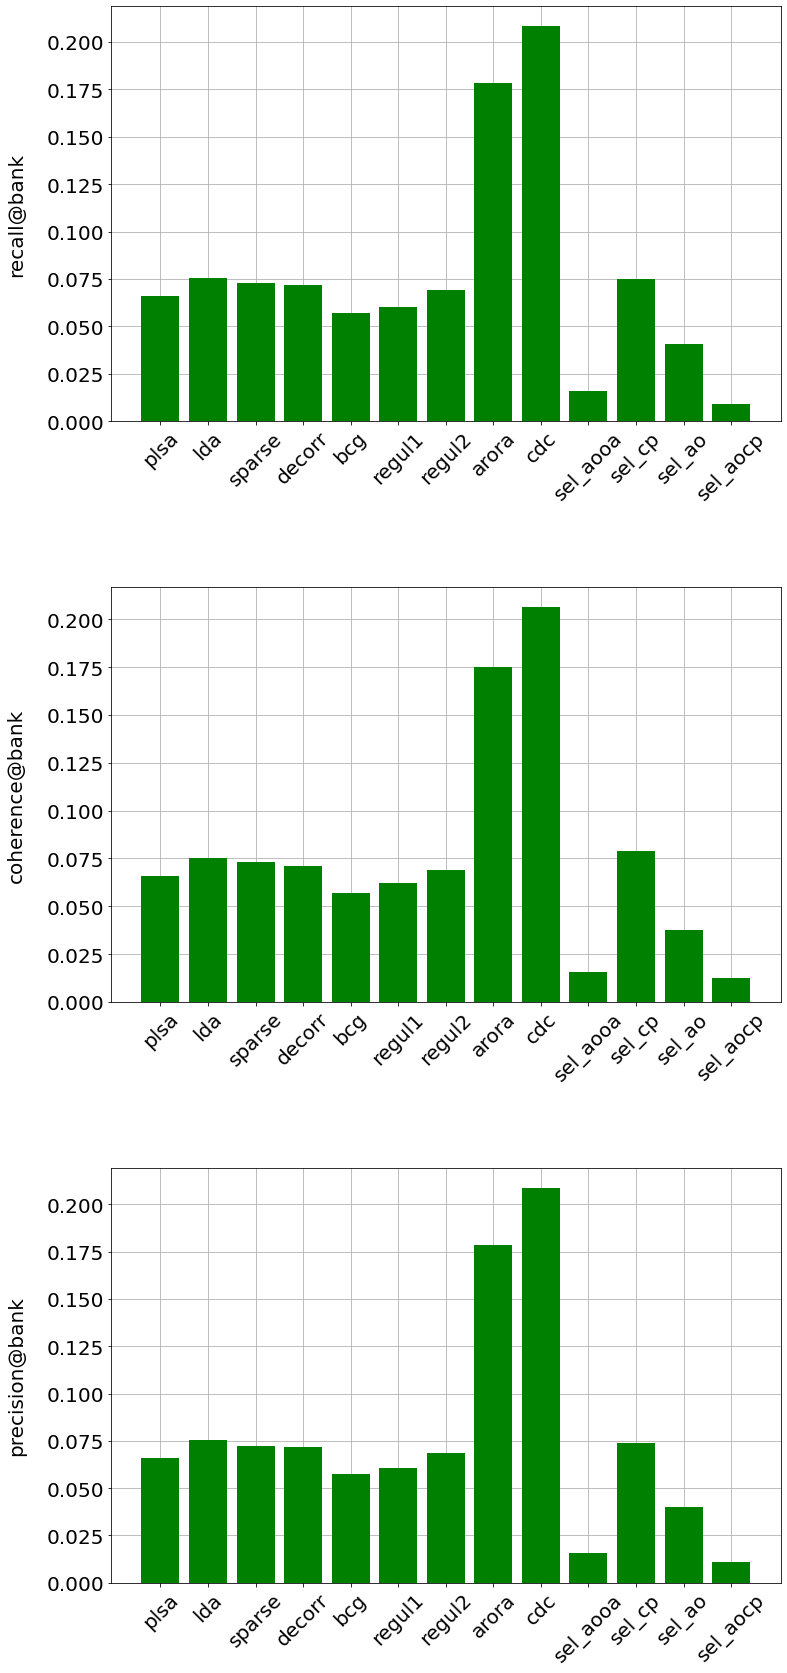

In [ ]:
metrics = [
    KEY_RECALL_AT_BANK,
    KEY_COHERENCE_AT_BANK,
    KEY_PRECISION_AT_BANK,
]
data_for_datasets = list(AVERAGED_ESTIMATES.values())

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 8 * len(metrics) + 5))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4
)

for ax, metric in zip(axes, metrics):
    draw_bar_plot(ax, metric, data_for_datasets)

plt.show()

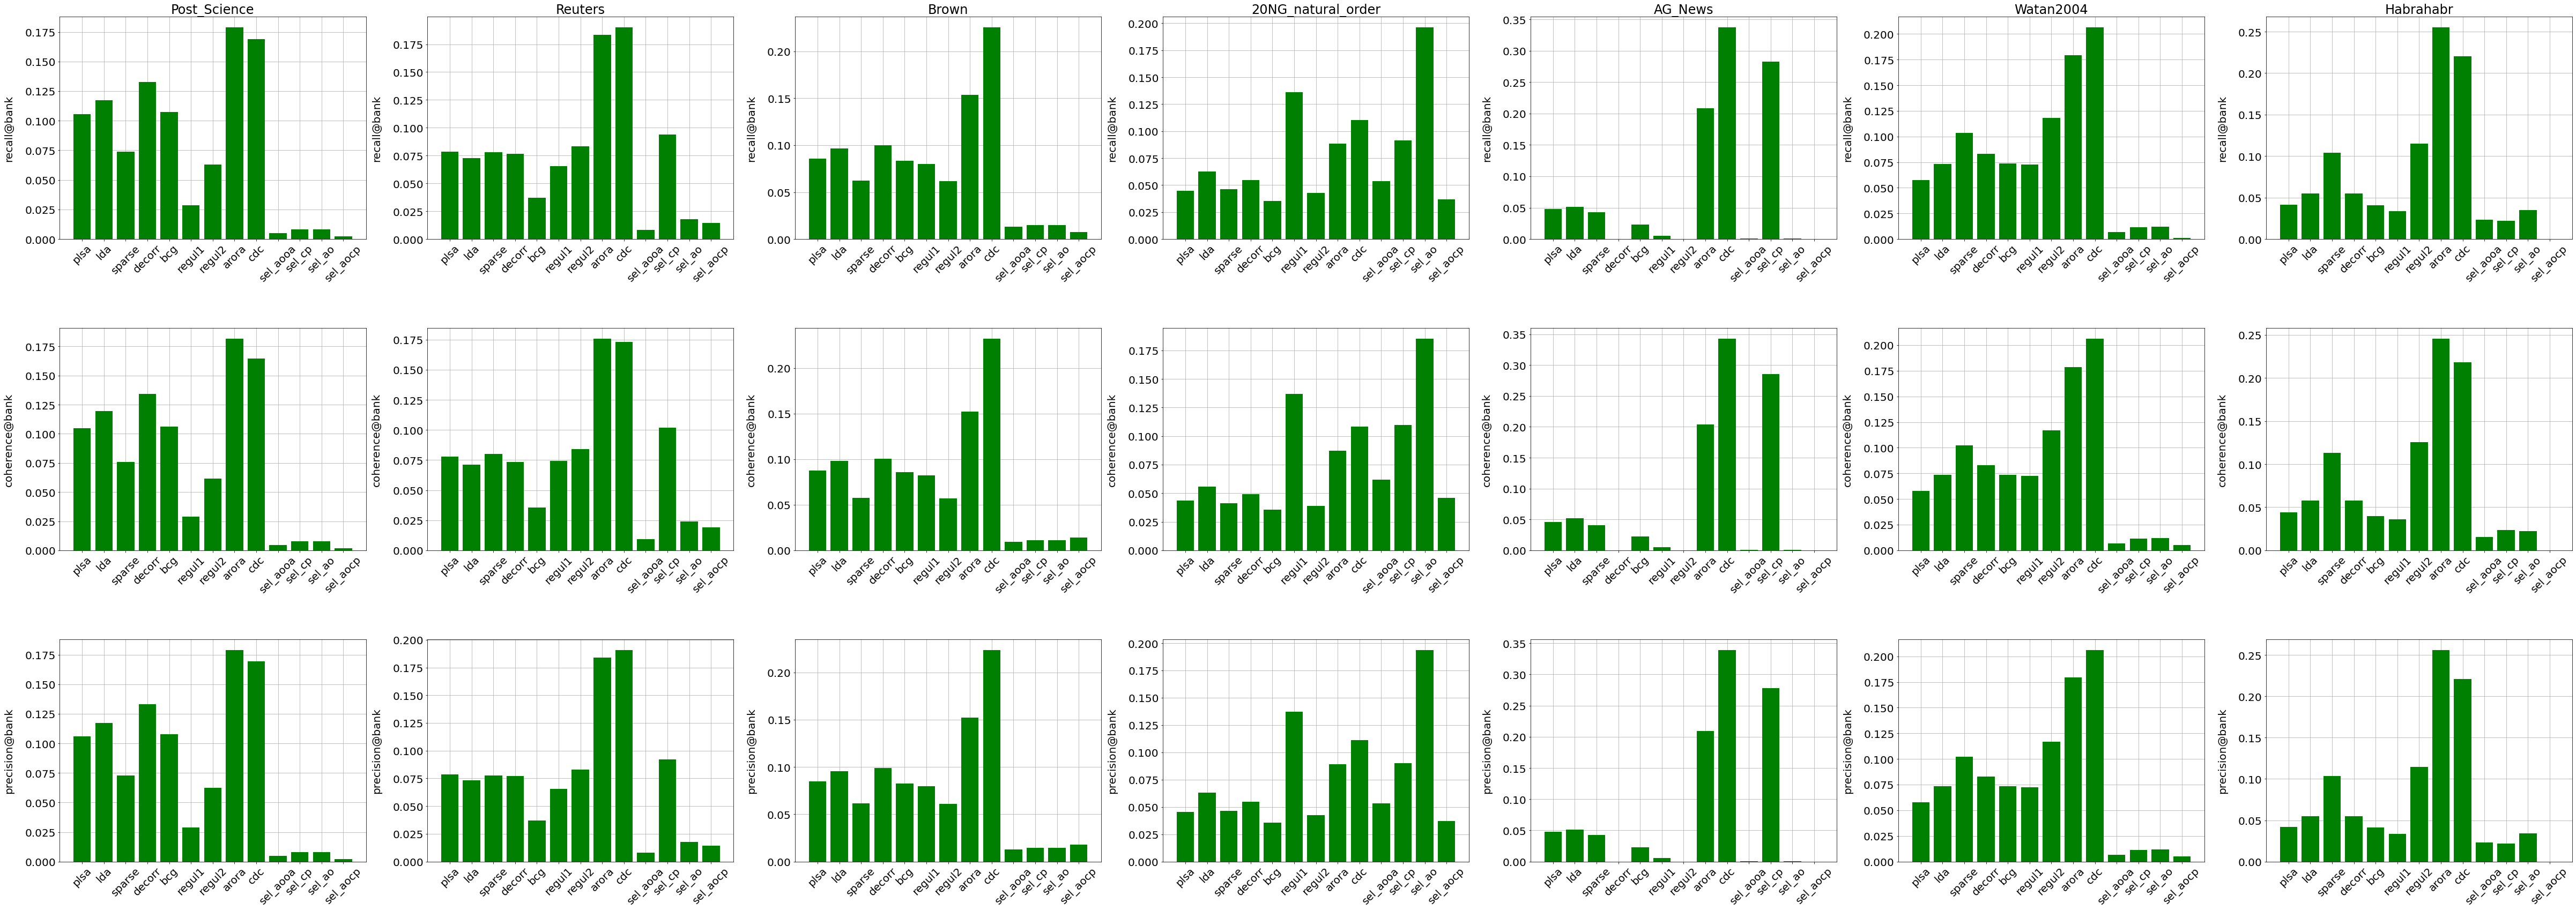

In [ ]:
metrics = [
    KEY_RECALL_AT_BANK,
    KEY_COHERENCE_AT_BANK,
    KEY_PRECISION_AT_BANK,
]

fig, axes = plt.subplots(
    len(metrics), len(DatasetName),
    figsize=(12 * len(DatasetName), 8 * len(metrics) + 5)
)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4
)

for j, dataset_folder_name in enumerate(DatasetName):
    data_for_datasets = [AVERAGED_ESTIMATES[dataset_folder_name]]
    
    for i, metric in enumerate(metrics):
        ax = axes[i, j]

        draw_bar_plot(ax, metric, data_for_datasets)
        
        if i == 0:
            ax.set_title(dataset_folder_name.value)

plt.show()

---

Arora and CDC turned out to be the best.

<div style="text-align: right">&#8718;</div>